In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys

if not os.path.exists(os.path.join(os.getcwd(), 'config.json')):
  # preventing to go always to the parent folder everytime we run the jupyter notebook without restarting
  os.chdir("..")
if not os.getcwd() in sys.path:
  sys.path.append(os.getcwd())

import json
from graph import Graph
from rank import Rank
from strategies import *
from analysis.analysis_commons import *
import matplotlib.pyplot as plt

config = None
with open('config.json') as config_file:
  config = json.load(config_file)
  config["database"]["database"] = "wikilite"

strategies_to_run = [
  RandomStrategy, 
  GreedyStrategy,
  MultiObjectiveStrategy
]

to_ignore = [
  # 'Declarative Language vs Procedural Language',
  # 'Optimism vs Pessimism',
  # 'Rationalism vs Empiricism',
  # 'Classical Economics vs Keynesian Economics',
]

flipped = True


In [33]:
f = open('data/datavoids_per_topic_filtered.json', 'r')
datavoids_per_topic = json.load(f)
check_repeated_keys(datavoids_per_topic)

selected_topics = [] 
with open('data/contrasting_arguments_labeled_stats_selected.csv', 'r') as f:
  reader = csv.DictReader(f)
  for r in reader:
    if int(r['Selected']) != 1:
      continue
    selected_topics.append(r['Mitigator'] + ' vs ' + r['Disinformer'])
datavoids_per_topic = {k: v for k, v in datavoids_per_topic.items() if k in selected_topics}
datavoids_per_topic = {k: v for k, v in datavoids_per_topic.items() if k not in to_ignore}

## Debug table (ignore for paper)

.........................................................

/Users/miro/Repos/misinformation/page-rank/analysis/analysis_commons.py:1005: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 1, squeeze=False)


...............

{'Declarative Language vs Procedural Language': 2.2770202020202026,
 'Optimism vs Pessimism': 3.4029078198666474,
 'Rationalism vs Empiricism': 3.6469754223395787,
 'Classical Economics vs Keynesian Economics': 4.9689248361376555}

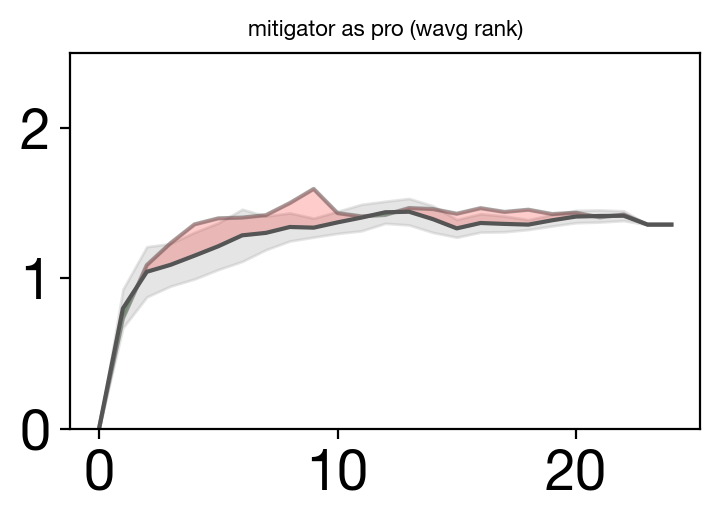

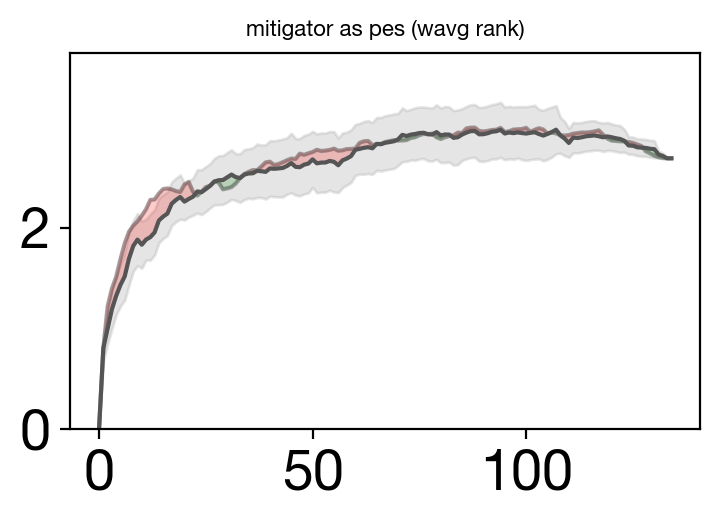

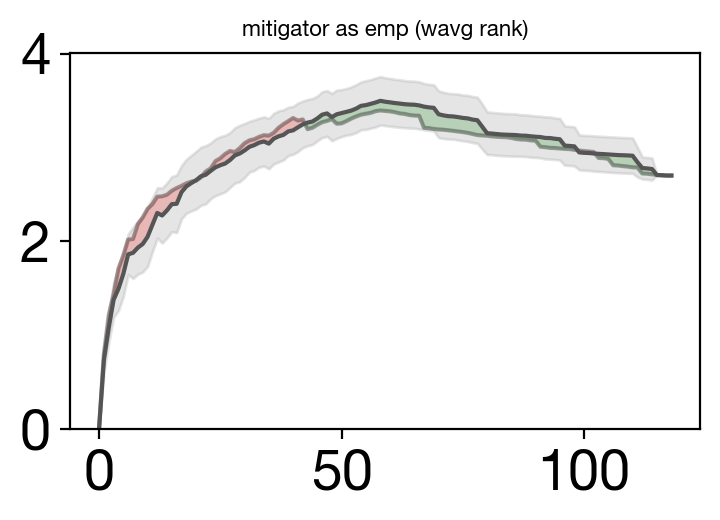

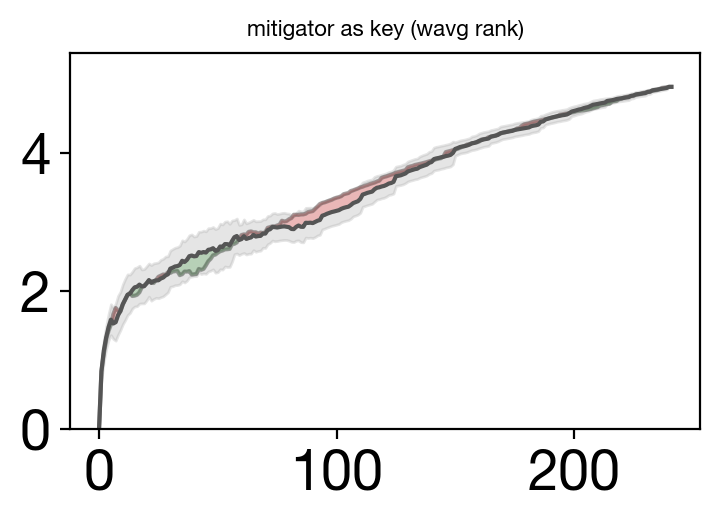

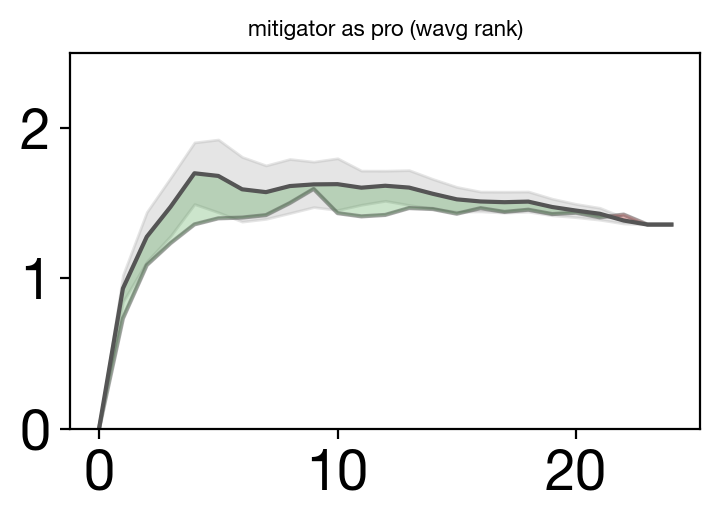

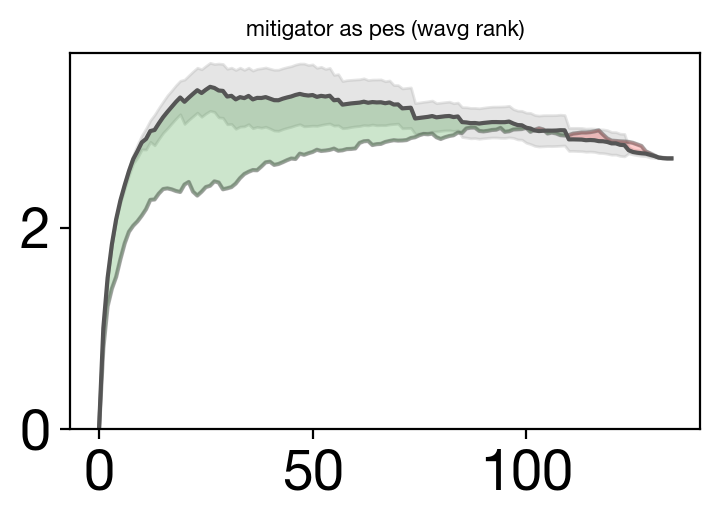

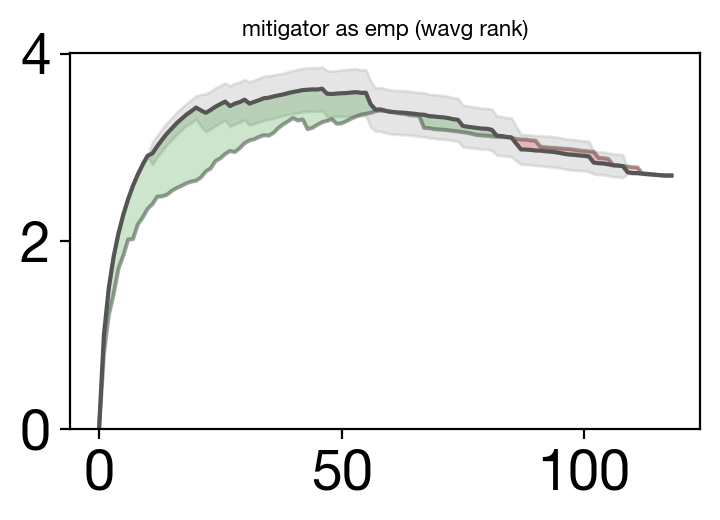

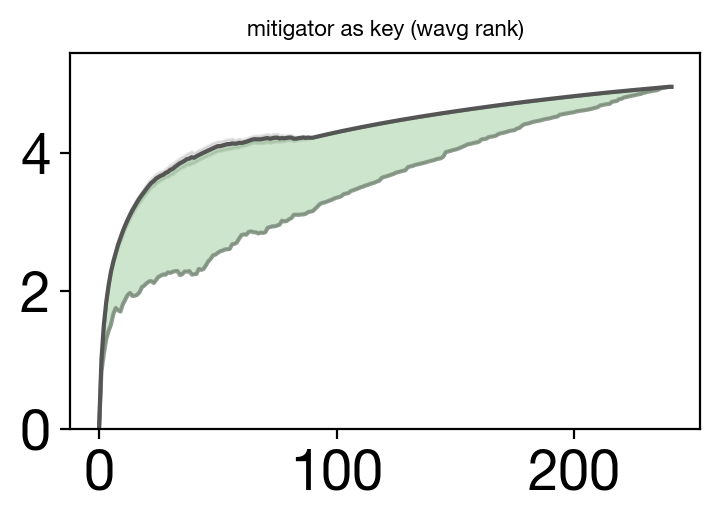

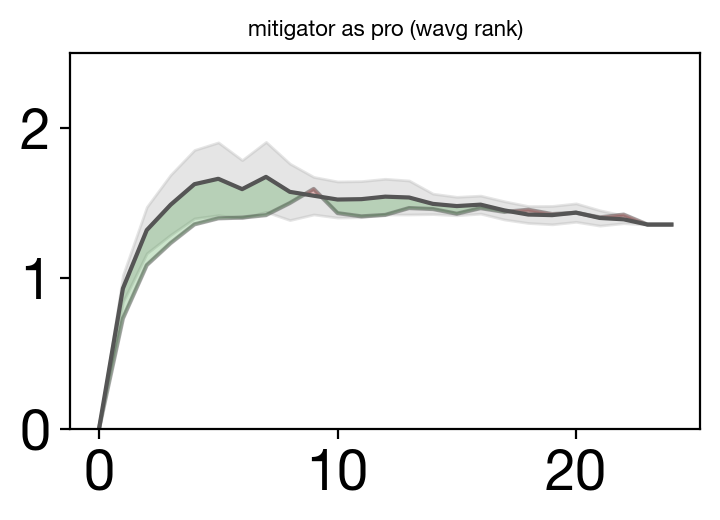

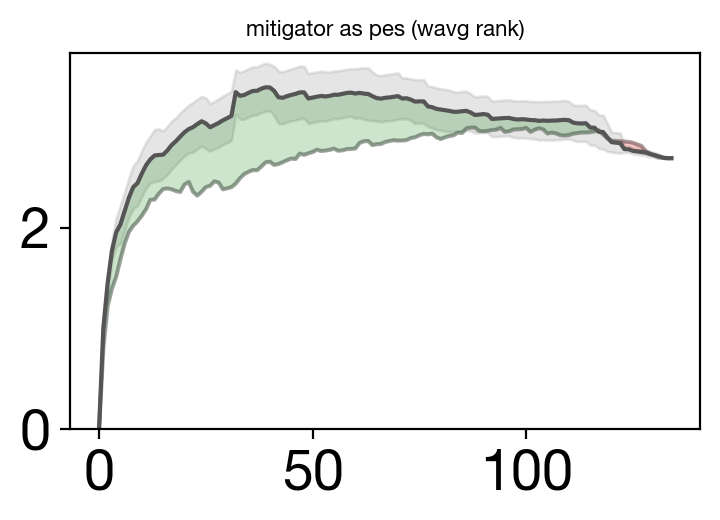

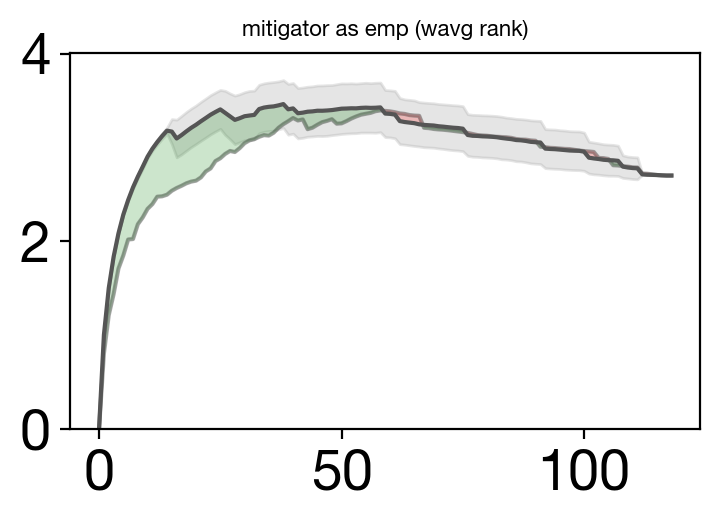

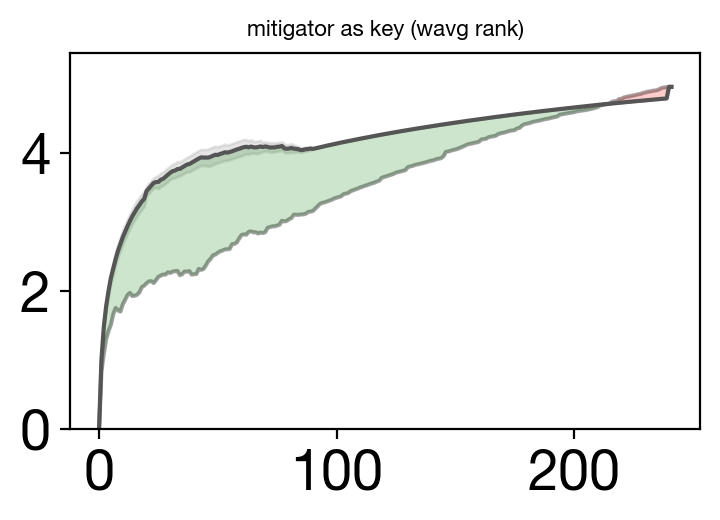

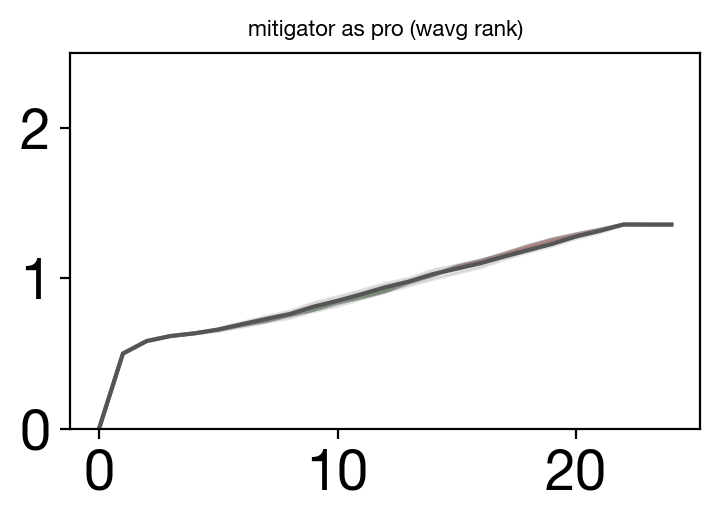

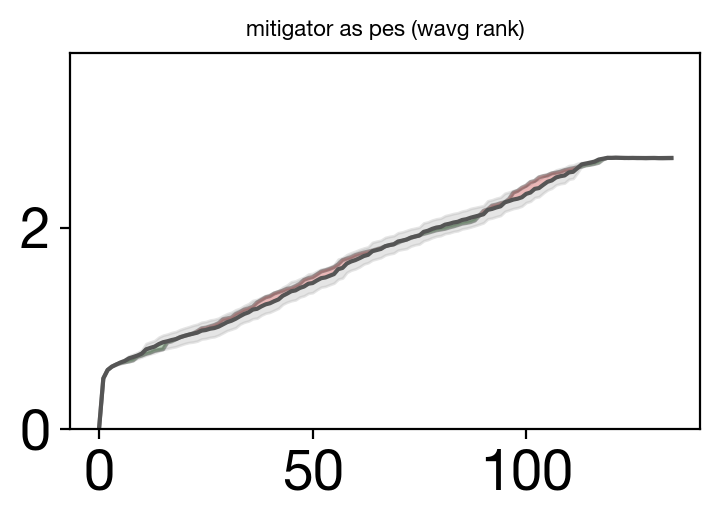

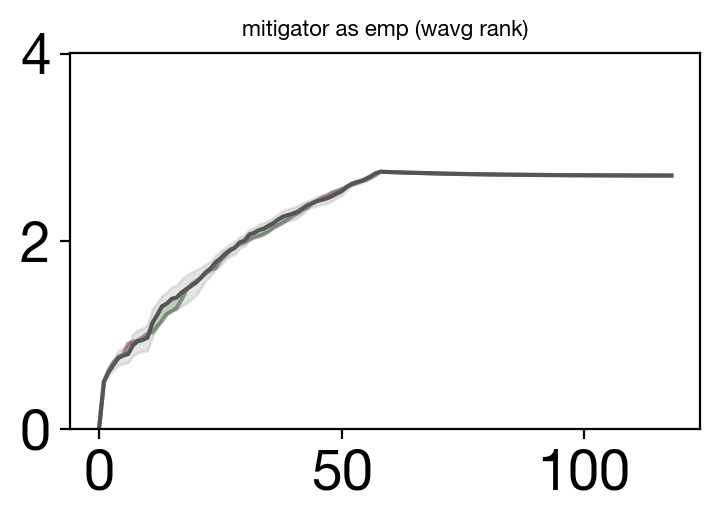

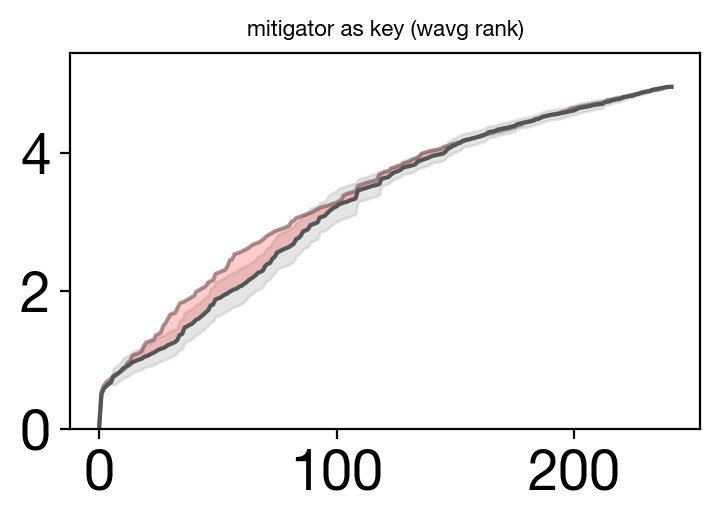

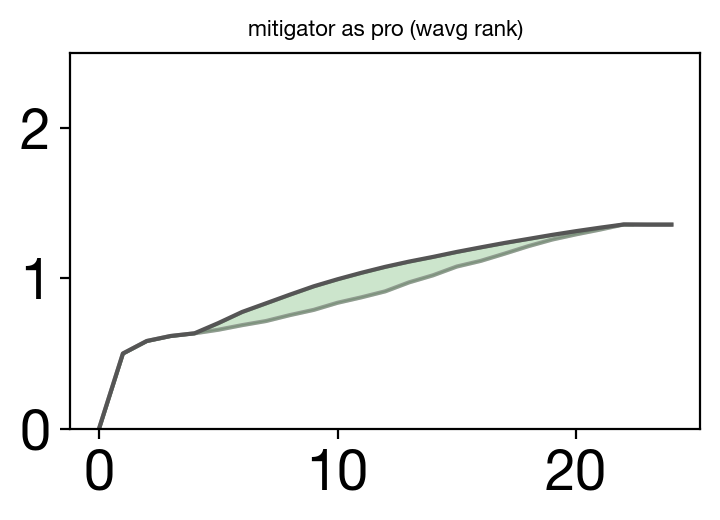

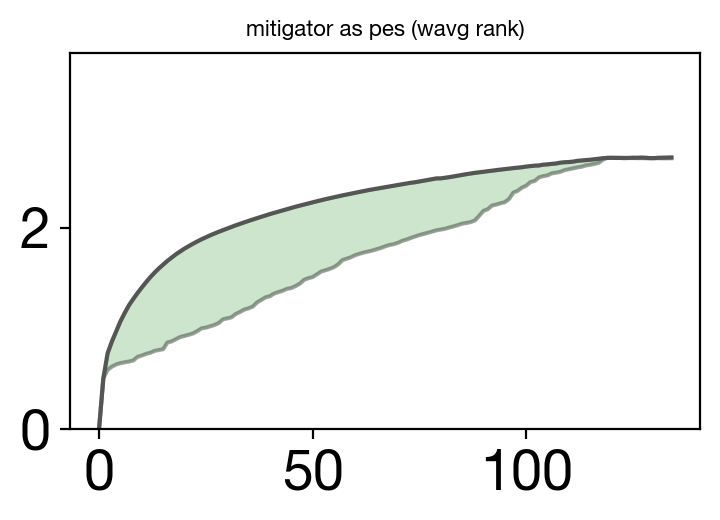

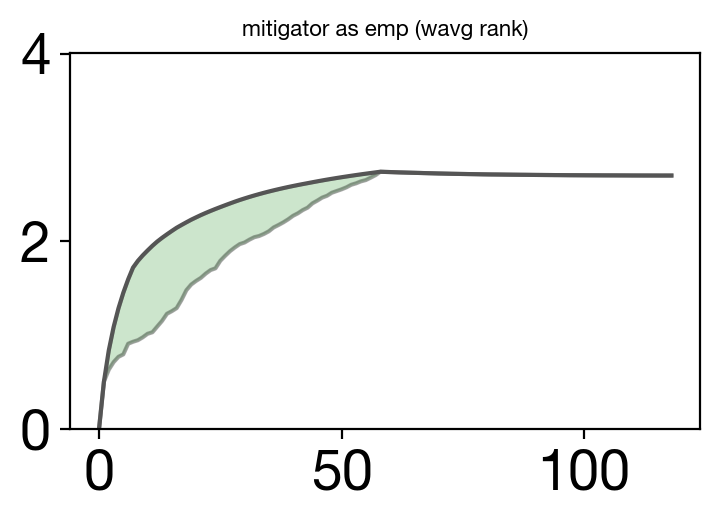

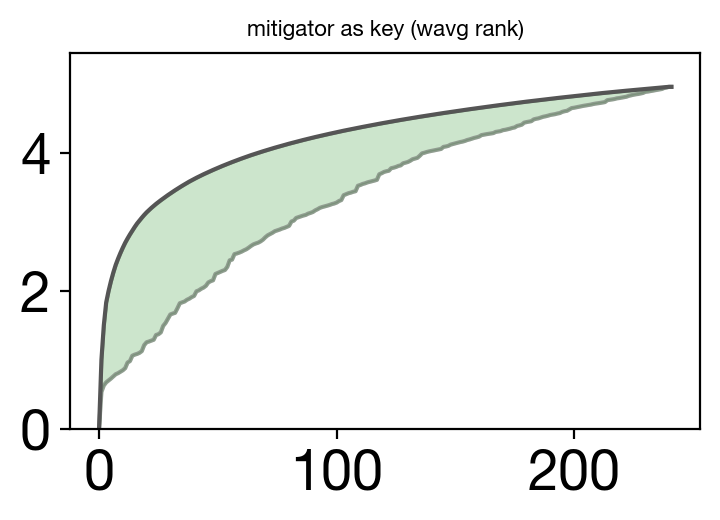

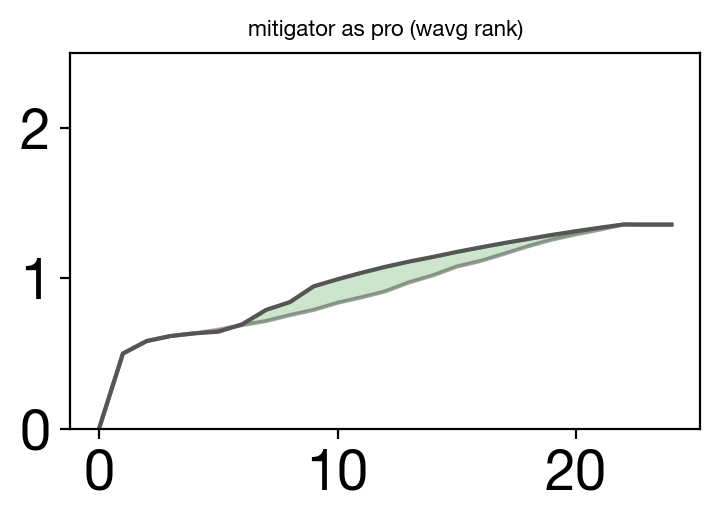

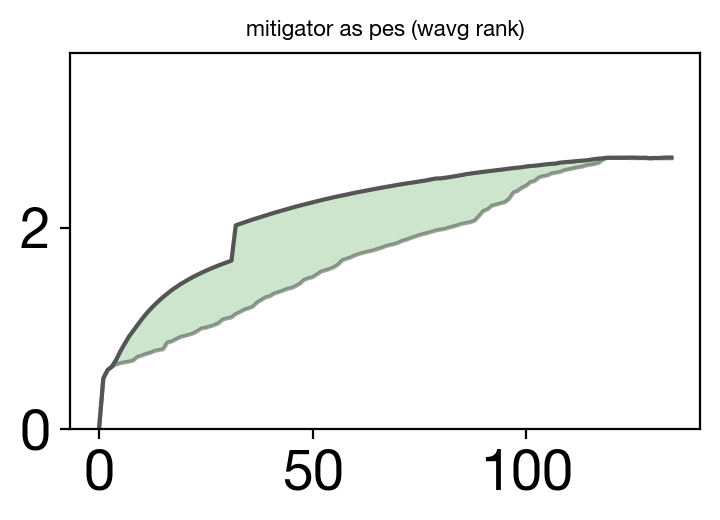

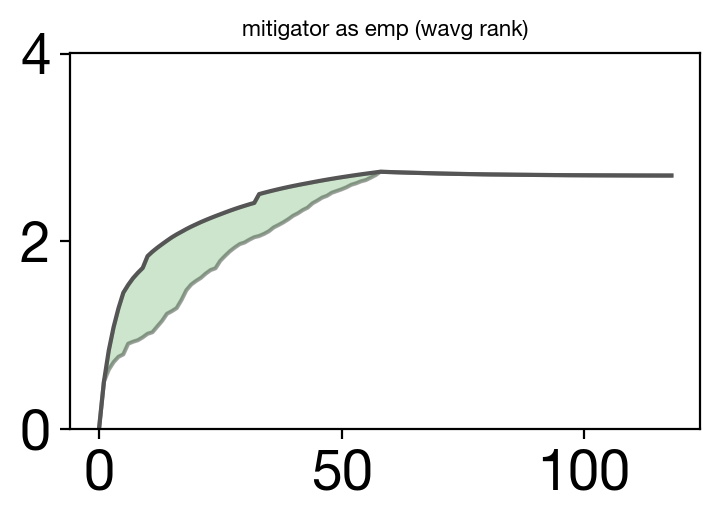

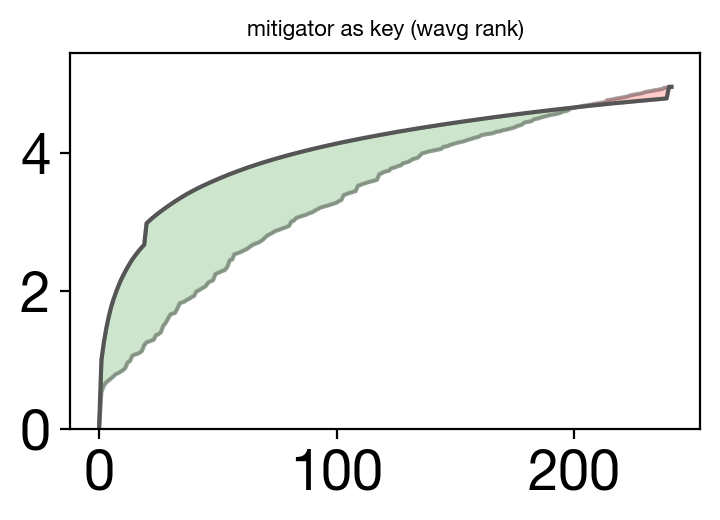

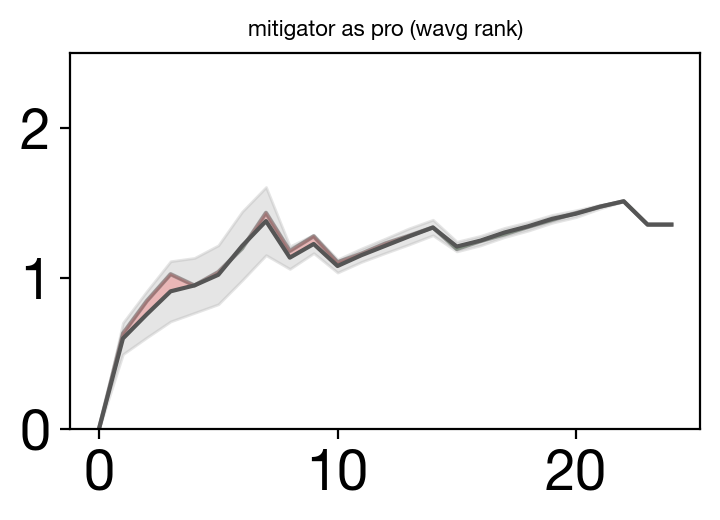

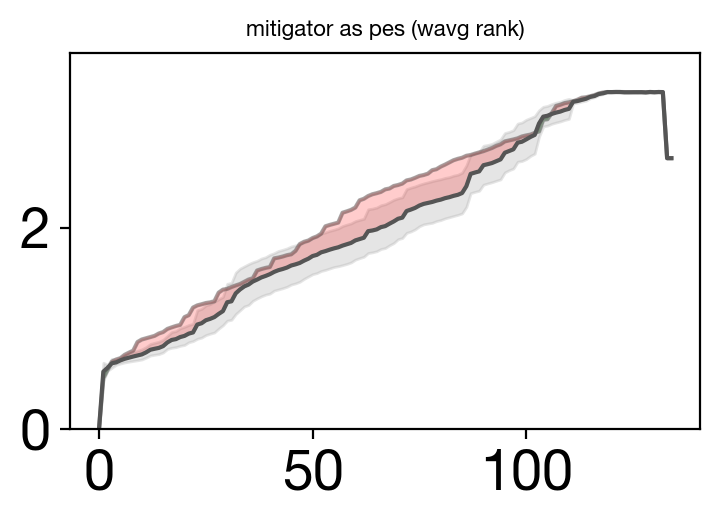

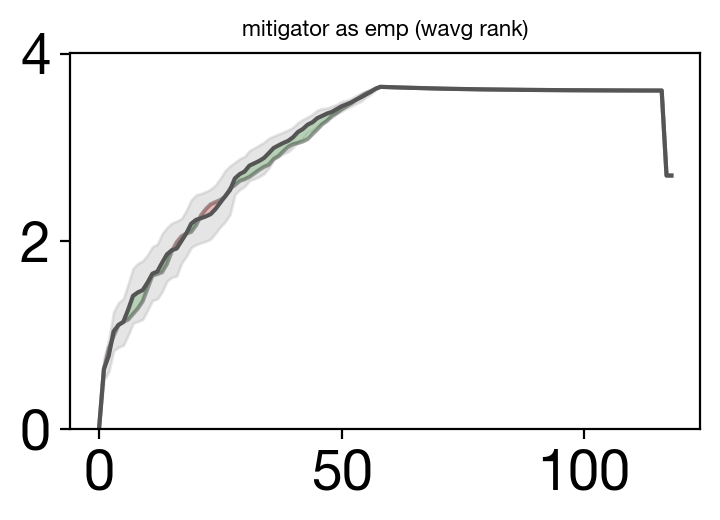

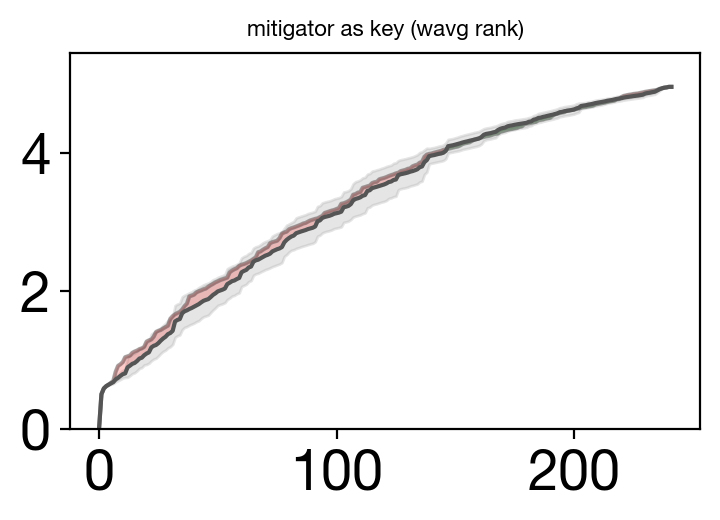

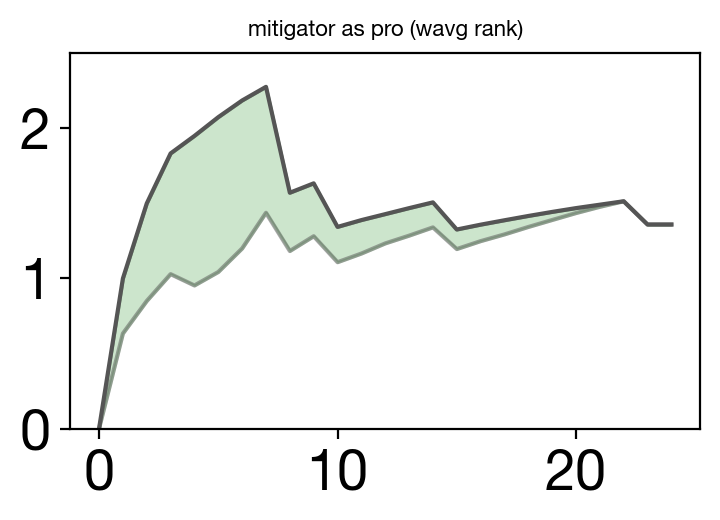

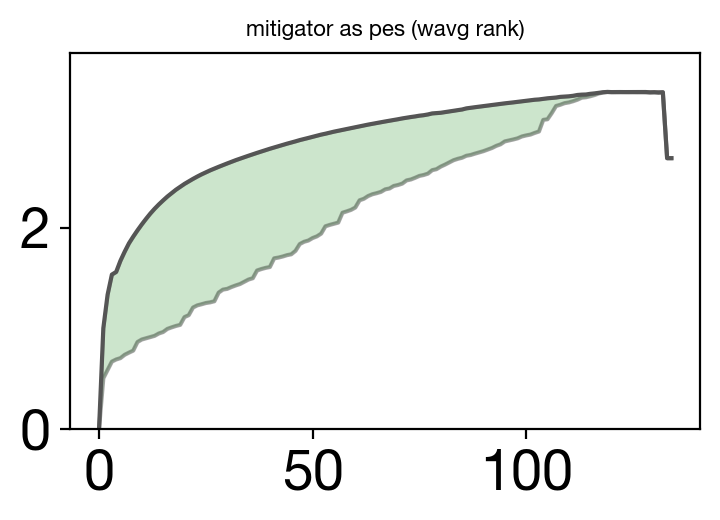

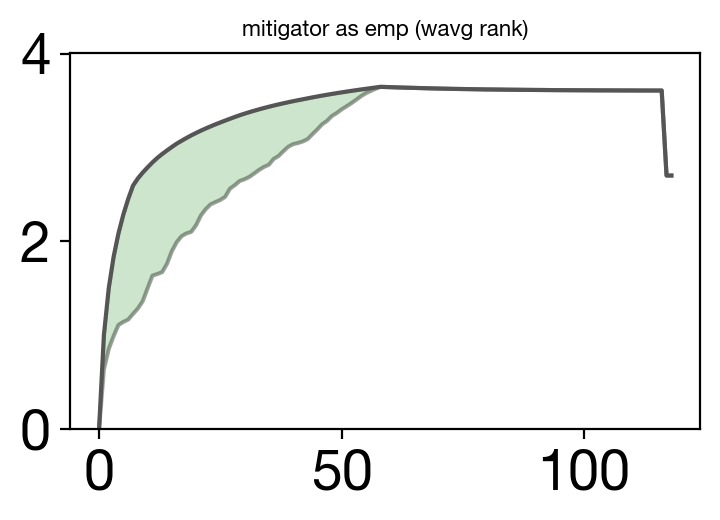

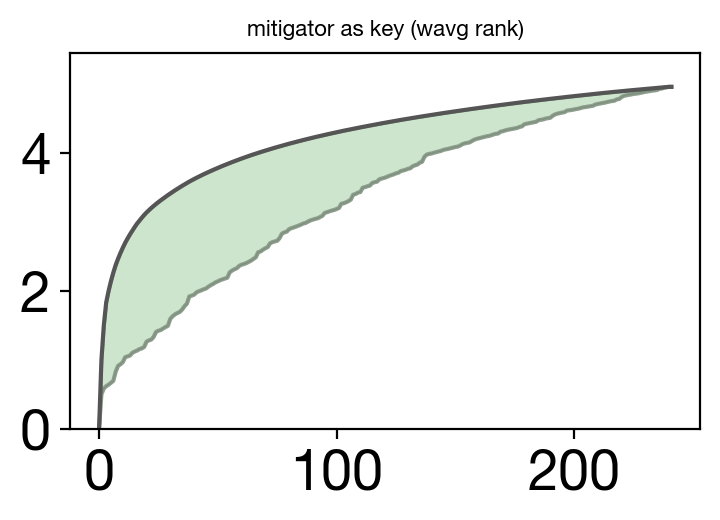

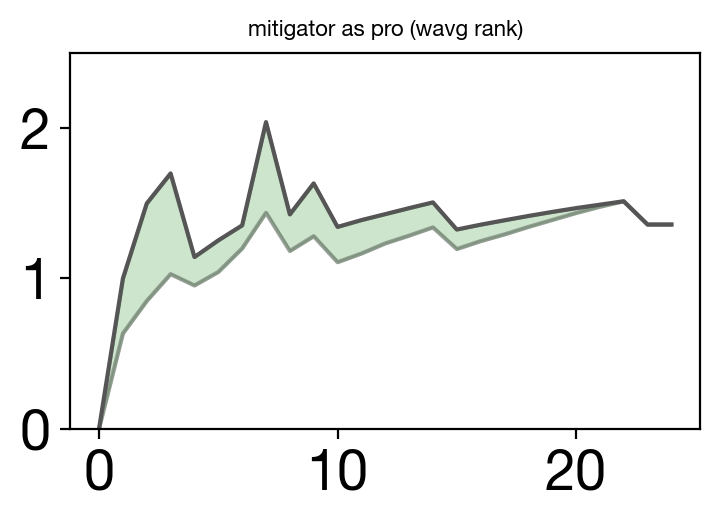

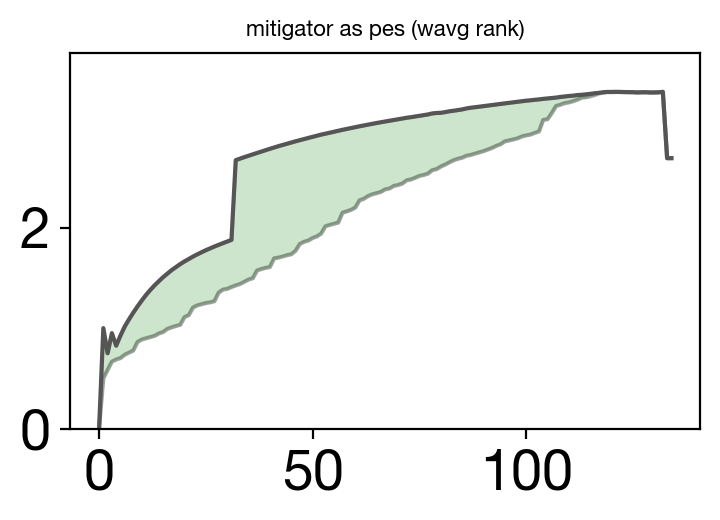

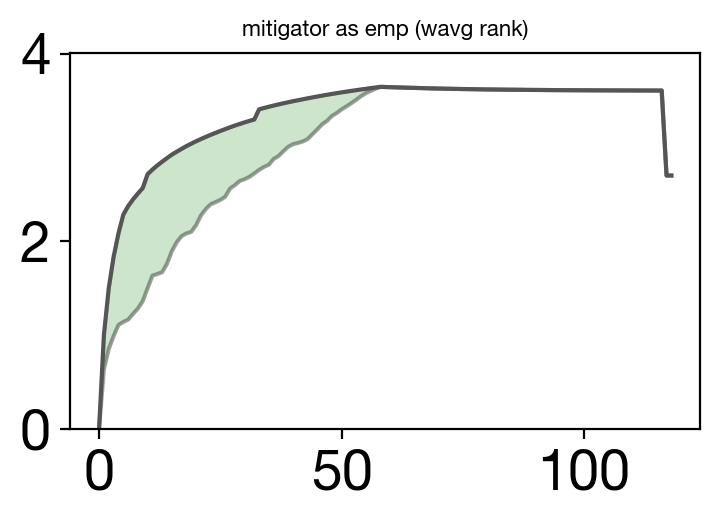

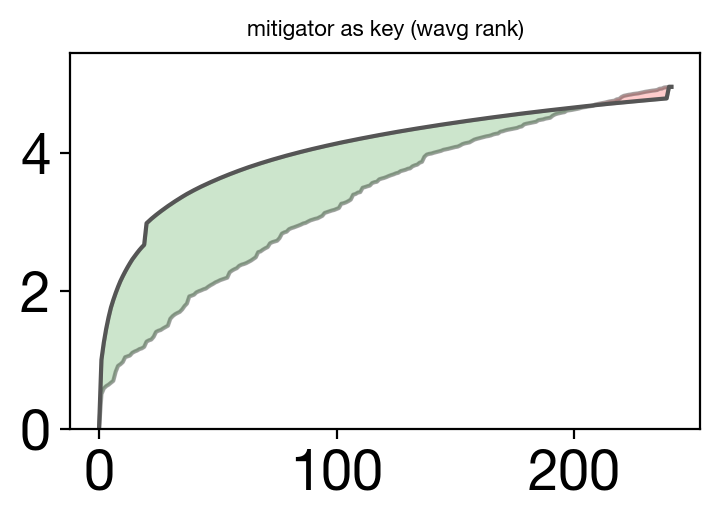

In [34]:
results_tb = open('results/evaluation-all-topics-table.html', 'w')

results_tb.write("""
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Strategy evaluation</title>
  <style>
    body, html {
      font-family: Helvetica Neue, sans-serif;
    }
    table, thead, tbody, tfoot, tr, th, td {
      width: auto;
      height: auto;
      margin: 0;
      padding: 0.5rem;
      border: 1px solid black; 
      border-collapse: inherit;
      border-spacing: 0;
      border-color: inherit;
      vertical-align: inherit;
      text-align: center;
      font-weight: inherit;
      -webkit-border-horizontal-spacing: 0;
      -webkit-border-vertical-spacing: 0;
    }
    th, td {
    }
    th {
      font-size: 300%;
      vertical-align: center;
    }
    th[rowspan] {
      writing-mode: vertical-lr;
      transform: rotate(180deg);
    }
    .test-label, .base-label {
      font-size: 300%;
    }
  </style>
</head>
<body>
""")


results_tb.write('<table border="1"><tr>')
results_tb.write(f"<th> </th>")
for topic in datavoids_per_topic.keys():
  topic_parts = topic.split(' vs ')
  if flipped:
    results_tb.write(f"<th>{topic_parts[1]} vs {topic_parts[0]}</th>")
  else:
    results_tb.write(f"<th>{topic_parts[0]} vs {topic_parts[1]}</th>")
results_tb.write("</tr>")

plot_y_max = {topic: 0 for topic in datavoids_per_topic.keys()} 
for find_y_max in [True, False]:
  for disinformer_strategy_class in strategies_to_run:
    if not find_y_max:
      results_tb.write("<tr>")
    disinformer_strategy_base = disinformer_strategy_class()
    mitigator_strategy_base = RandomStrategy()
    if not find_y_max:
      results_tb.write(f"<th rowspan=\"{len(strategies_to_run)}\">" + readable_strategy_name(disinformer_strategy_base) + "</th>")
    simulation_label_base = f'eval-all-base-{mitigator_strategy_base.get_strategy_name()}-{disinformer_strategy_base.get_strategy_name()}'

    for mitigator_strategy_class in strategies_to_run:
      disinformer_strategy = disinformer_strategy_class()
      mitigator_strategy = mitigator_strategy_class()

      # # Don't diplay control simulations
      # if disinformer_strategy_base.get_strategy_name() == disinformer_strategy.get_strategy_name() and \
      #    mitigator_strategy_base.get_strategy_name() == mitigator_strategy.get_strategy_name():
        #  continue

      simulation_label = f'eval-all-{mitigator_strategy.get_strategy_name()}-{disinformer_strategy.get_strategy_name()}'

      for topic in datavoids_per_topic.keys():
        datavoids = datavoids_per_topic[topic]['datavoids']
        config['datavoids'] = [datavoids]
        topic_parts = topic.split(' vs ')

        mitigator_id = datavoids_per_topic[topic]['mitigator_id']
        disinformer_id = datavoids_per_topic[topic]['disinformer_id']
        mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
        disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
        current_config = None
        topic_label = f"{mitigator_label}-{disinformer_label}"
          
        if flipped:
          current_config = clone_config_with_target(config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
          current_config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
        else:
          current_config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
          current_config['topic_name'] = topic 

        sim_filename_base = 'results/' + create_simulation_name(current_config, simulation_label_base)
        sim_filename = 'results/' + create_simulation_name(current_config, simulation_label)
        plot_filename = f'results/images/{topic_label}-{simulation_label_base}-{simulation_label}.png'

        if os.path.exists(sim_filename_base) and os.path.exists(sim_filename):
          current_config["output_filename"] = sim_filename_base
          steps_per_strategy_base, strategies_base, id_max_rank_base = get_output(current_config)

          current_config["output_filename"] = sim_filename
          steps_per_strategy, strategies, id_max_rank = get_output(current_config)

          if find_y_max:
            yrange = plot_differences_against_base_ranges(
              current_config['target_groups'][0],
              strategies_base[0],
              strategies[0], 
              steps_per_strategy_base, 
              steps_per_strategy, 
              current_config,
            )
            if yrange[1] > plot_y_max[topic]:
              plot_y_max[topic] = yrange[1]
          else:
            plot_fig = plot_differences_against_base(
              f"mitigator as {current_config['target_groups'][0]} (wavg rank)",
              current_config['target_groups'][0],
              strategies_base[0],
              strategies[0], 
              steps_per_strategy_base, 
              steps_per_strategy, 
              current_config,
              y_max=plot_y_max[topic] * 1.1,

              show=False
            )
            plot_fig.savefig(plot_filename)

        if not find_y_max:
          results_tb.write(f"""<td>
            <div class="base-label">base: {mitigator_strategy_base.get_strategy_name()} vs {disinformer_strategy_base.get_strategy_name()}</div>
            <div class="test-label">test: {mitigator_strategy.get_strategy_name()} vs {disinformer_strategy.get_strategy_name()}</div>
            <img src=\"{plot_filename.replace("results/", "")}\" />
          </td>""")

        print('.', end='')

      if not find_y_max:
        results_tb.write("</tr>")

    if not find_y_max:
      results_tb.write("</tr>")
      results_tb.write(f"<tr><td colspan=\"{len(datavoids_per_topic.keys()) + 1}\">&nbsp;</td></tr>")

results_tb.write("</table>")
results_tb.write("</body></html>")

results_tb.close()

plot_y_max

## Inverse rank when all pages have been added

In [36]:
for topic_idx, topic in enumerate(datavoids_per_topic.keys()):
  topic_parts = topic.split(' vs ')
  mitigator_id = datavoids_per_topic[topic]['mitigator_id']
  disinformer_id = datavoids_per_topic[topic]['disinformer_id']
  mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
  disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
  current_config = None
  topic_label = f"{mitigator_label}-{disinformer_label}"

  if flipped:
    current_config = clone_config_with_target(config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
    current_config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
    mitigator_label, disinformer_label, _ = current_config['target_groups']
  else:
    current_config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
    current_config['topic_name'] = topic 

  datavoids = datavoids_per_topic[topic]['datavoids']
  current_config['datavoids'] = [datavoids]

  sim_filename = 'results/' + create_simulation_name(current_config, simulation_label)
  plot_filename = f'results/images_against_disinformer/{topic_label}-{simulation_label_base}-{simulation_label}.png'
  plot_filename_pdf = f'results/images_against_disinformer/{topic_label}-{simulation_label_base}-{simulation_label}.pdf'

  current_config["output_filename"] = sim_filename
  steps_per_strategy, strategies, id_max_rank = get_output(current_config)

  last_step = max(steps_per_strategy[strategies[0]].keys())

  mit_ranks = steps_per_strategy[strategies[0]][last_step][mitigator_label]['weighted_avg_rank']
  dis_ranks = steps_per_strategy[strategies[0]][last_step][disinformer_label]['weighted_avg_rank']
  print(f"Mitigator ({mitigator_label}) wavgrank: {sum(mit_ranks) / len(mit_ranks):.2f}")
  print(f"Disinformer ({disinformer_label}) wavgrank: {sum(dis_ranks) / len(dis_ranks):.2f}")

Mitigator (pro) wavgrank: 1.36
Disinformer (dec) wavgrank: 3.04
Mitigator (pes) wavgrank: 2.69
Disinformer (opt) wavgrank: 3.42
Mitigator (emp) wavgrank: 2.70
Disinformer (rat) wavgrank: 3.04
Mitigator (key) wavgrank: 4.97
Disinformer (cla) wavgrank: 1.41


## Some numbers to back up claims

In [50]:
def per_topic(mit_strategy, mit_strategy_base, dis_strategy, dis_strategy_base):
  for topic in datavoids_per_topic.keys():
    mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
    disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
    current_config = None
    if flipped:
      current_config = clone_config_with_target(config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
      topic_parts = topic.split(' vs ')
      current_config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
    else:
      current_config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
      current_config['topic_name'] = topic 

    simulation_label_base = f'eval-all-base-{mit_strategy_base.get_strategy_name()}-{dis_strategy_base.get_strategy_name()}'
    sim_filename_base = 'results/' + create_simulation_name(current_config, simulation_label_base)
    simulation_label = f'eval-all-{mit_strategy.get_strategy_name()}-{dis_strategy.get_strategy_name()}'
    sim_filename = 'results/' + create_simulation_name(current_config, simulation_label)

    current_config["output_filename"] = sim_filename_base
    steps_per_strategy_base, strategies_base, id_max_rank_base = get_output(current_config)
    base_steps = steps_per_strategy_base[strategies_base[0]]

    current_config["output_filename"] = sim_filename
    steps_per_strategy, strategies, id_max_rank = get_output(current_config)
    steps = steps_per_strategy[strategies[0]]

    yield (base_steps, steps, current_config)

def per_dis_strategy(mit_strategy, dis_strategies):
  dis_strategy_base = RandomStrategy()
  mit_strategy_base = RandomStrategy()
  for dis_strategy in dis_strategies:
    yield from per_topic(mit_strategy(), mit_strategy_base, dis_strategy(), dis_strategy_base)

mit_strategy = GreedyStrategy()

greedy_above = 0
other_above = 0
total = 0
for base_steps, steps, current_config in per_dis_strategy(GreedyStrategy, [RandomStrategy, MultiObjectiveStrategy]):
  max_steps = min(
    max([int(s) for s in base_steps.keys()]),
    max([int(s) for s in steps.keys()])
  )
  mitigator_label, disinformer_label, _ = current_config['target_groups']
  for step in range(max_steps // 2):
    vals_d_base = base_steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m_base = base_steps[step][mitigator_label]["weighted_avg_rank"]
    vals_d = steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m = steps[step][mitigator_label]["weighted_avg_rank"]

    y_val_base = (sum(vals_m_base) / len(vals_m_base)) - (sum(vals_d_base) / len(vals_d_base))
    y_val = (sum(vals_m) / len(vals_m)) - (sum(vals_d) / len(vals_d))


    if y_val > y_val_base:
      greedy_above += 1
    if y_val_base > y_val:
      other_above += 1
    total += 1
  
print(f"Greedy above: {greedy_above / total}")
print(f"Greedy above: {other_above / total}")



Greedy above: 0.9554263565891473
Greedy above: 0.029069767441860465


In [51]:
# A random strategy has little chance at outperforming a strategic disinformer
# But how little?

random_above = 0
other_above = 0
total = 0
for base_steps, steps, current_config in per_dis_strategy(RandomStrategy, [GreedyStrategy, MultiObjectiveStrategy]):
  max_steps = min(
    max([int(s) for s in base_steps.keys()]),
    max([int(s) for s in steps.keys()])
  )
  mitigator_label, disinformer_label, _ = current_config['target_groups']
  for step in range(max_steps // 2):
    vals_d_base = base_steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m_base = base_steps[step][mitigator_label]["weighted_avg_rank"]
    vals_d = steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m = steps[step][mitigator_label]["weighted_avg_rank"]

    y_val_base = (sum(vals_m_base) / len(vals_m_base)) - (sum(vals_d_base) / len(vals_d_base))
    y_val = (sum(vals_m) / len(vals_m)) - (sum(vals_d) / len(vals_d))

    if y_val > y_val_base:
      random_above += 1
    if y_val_base > y_val:
      other_above += 1
    total += 1

print(f"Random above: {random_above / total}")
print(f"Other above: {other_above / total}")


Random above: 0.30174081237911027
Other above: 0.690522243713733


In [82]:
# they may not yield as many ``wins'' against the disinformer

multiobjective_above = 0
greedy_above = 0
other_above = 0
total = 0
for base_steps, steps, current_config in per_dis_strategy(GreedyStrategy, [RandomStrategy]):
  max_steps = min(
    max([int(s) for s in base_steps.keys()]),
    max([int(s) for s in steps.keys()])
  )
  mitigator_label, disinformer_label, _ = current_config['target_groups']
  for step in range(max_steps):
    vals_d_base = base_steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m_base = base_steps[step][mitigator_label]["weighted_avg_rank"]
    vals_d = steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m = steps[step][mitigator_label]["weighted_avg_rank"]

    y_val_base = (sum(vals_m_base) / len(vals_m_base)) - (sum(vals_d_base) / len(vals_d_base))
    y_val = (sum(vals_m) / len(vals_m)) - (sum(vals_d) / len(vals_d))

    if y_val > y_val_base:
      greedy_above += 1
    if y_val_base > y_val:
      other_above += 1
    total += 1

print(f"Greedy above: {greedy_above / total}")
print(f"Other above: {other_above / total}")

multiobjective_above = 0
other_above = 0
total = 0
for base_steps, steps, current_config in per_dis_strategy(MultiObjectiveStrategy, [RandomStrategy]):
  max_steps = min(
    max([int(s) for s in base_steps.keys()]),
    max([int(s) for s in steps.keys()])
  )
  mitigator_label, disinformer_label, _ = current_config['target_groups']
  for step in range(max_steps):
    vals_d_base = base_steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m_base = base_steps[step][mitigator_label]["weighted_avg_rank"]
    vals_d = steps[step][disinformer_label]["weighted_avg_rank"]
    vals_m = steps[step][mitigator_label]["weighted_avg_rank"]

    y_val_base = (sum(vals_m_base) / len(vals_m_base)) - (sum(vals_d_base) / len(vals_d_base))
    y_val = (sum(vals_m) / len(vals_m)) - (sum(vals_d) / len(vals_d))

    if y_val > y_val_base:
      multiobjective_above += 1
    if y_val_base > y_val:
      other_above += 1
    total += 1

print(f"Multiobjective above: {multiobjective_above / total}")
print(f"Other above: {other_above / total}")

print(f"diff: {((multiobjective_above - greedy_above) / greedy_above)}")

Greedy above: 0.874274661508704
Other above: 0.11798839458413926
Multiobjective above: 0.8278529980657641
Other above: 0.1644100580270793
diff: -0.05309734513274336


In [68]:
# Multiobjective initially, they are less expensive than greedy strategies

greedy_cost_initially = []
multiobjective_cost_initially = []
other_above = 0
total = 0
for base_steps, steps, current_config in per_dis_strategy(GreedyStrategy, [RandomStrategy]):
  max_steps = min(max([int(s) for s in base_steps.keys()]), max([int(s) for s in steps.keys()]))
  mitigator_label, disinformer_label, _ = current_config['target_groups']
  costs = steps[max_steps // 5][mitigator_label]["cost"]
  greedy_cost_initially.append(sum(costs) / len(costs))

for base_steps, steps, current_config in per_dis_strategy(MultiObjectiveStrategy, [RandomStrategy]):
  max_steps = min(max([int(s) for s in base_steps.keys()]), max([int(s) for s in steps.keys()]))
  mitigator_label, disinformer_label, _ = current_config['target_groups']
  costs = steps[max_steps // 5][mitigator_label]["cost"]
  multiobjective_cost_initially.append(sum(costs) / len(costs))
  
print(f"Greedy cost initially:         {greedy_cost_initially}")
print(f"Multiobjective cost initially: {multiobjective_cost_initially}")
diff_costs = [b / a for a,b in zip(greedy_cost_initially, multiobjective_cost_initially)]
diff_costs


Greedy cost initially:         [7.5687240924855255, 36.64143068361362, 35.34187173425186, 69.92534377592482]
Multiobjective cost initially: [6.253407722676429, 35.52482816951296, 34.3240357947153, 68.50883151305653]


[0.8262168955114925,
 0.9695262304645758,
 0.9712002820000584,
 0.9797425055583926]

## Table generic

............................................

/Users/miro/Repos/misinformation/page-rank/analysis/analysis_commons.py:836: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 1, squeeze=False)


....

3.5600269666254345

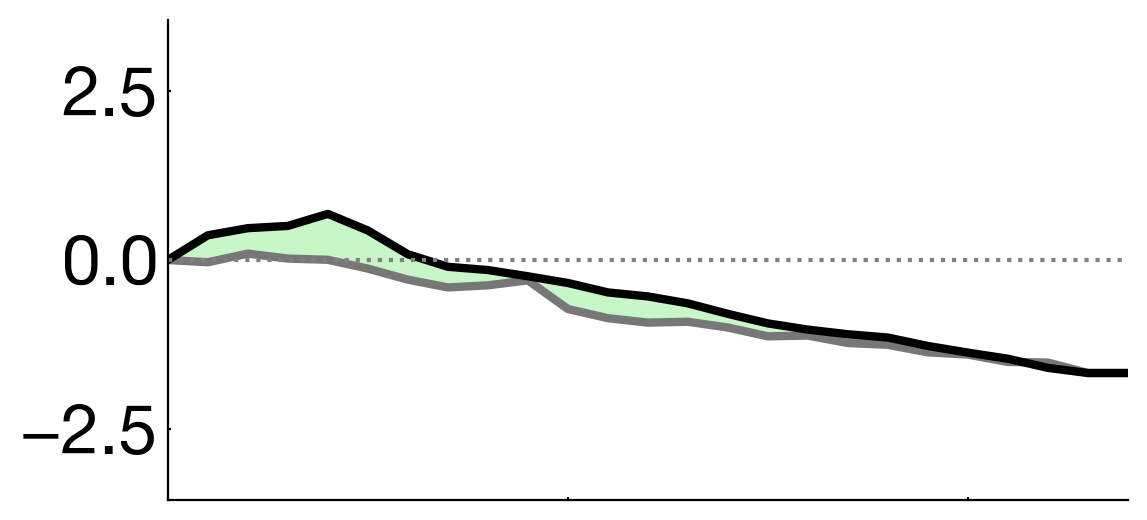

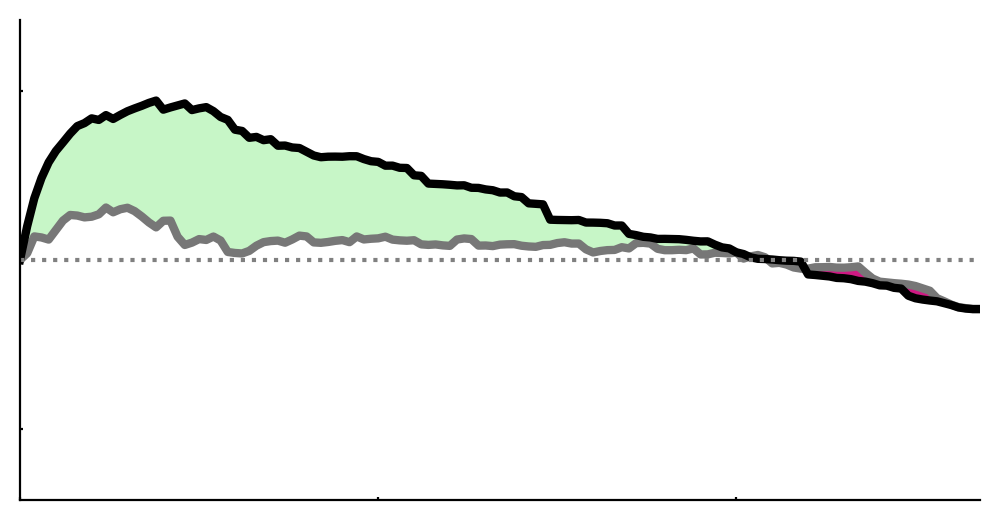

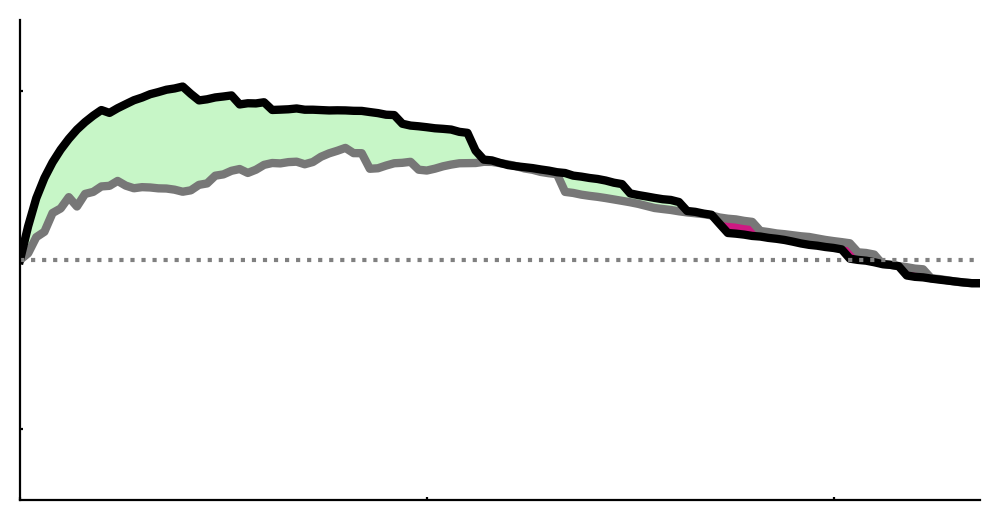

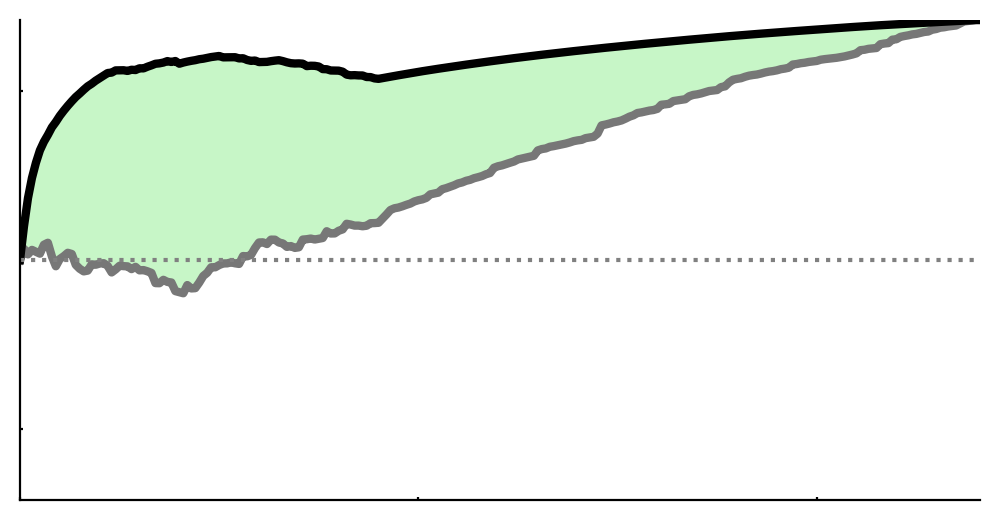

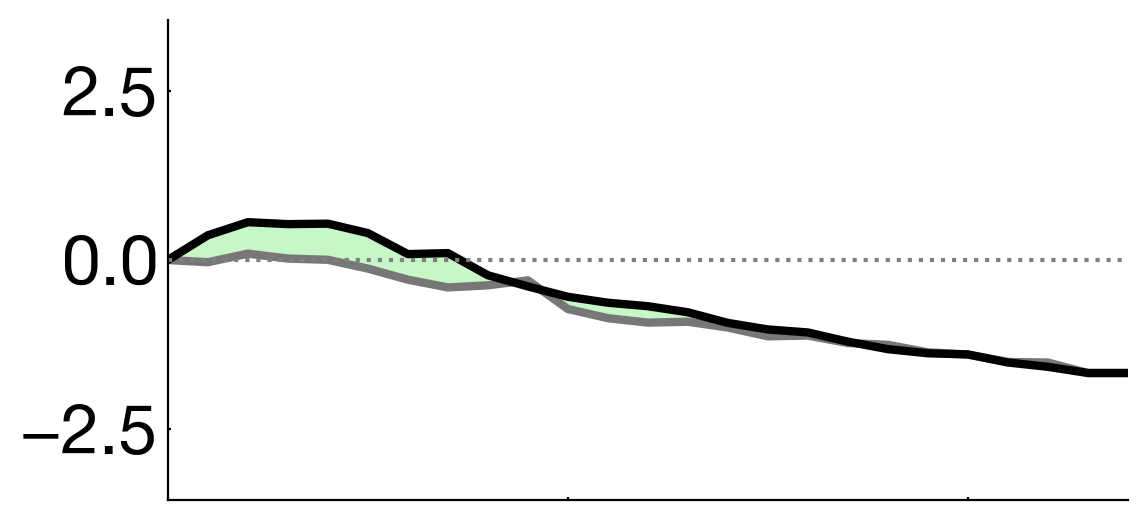

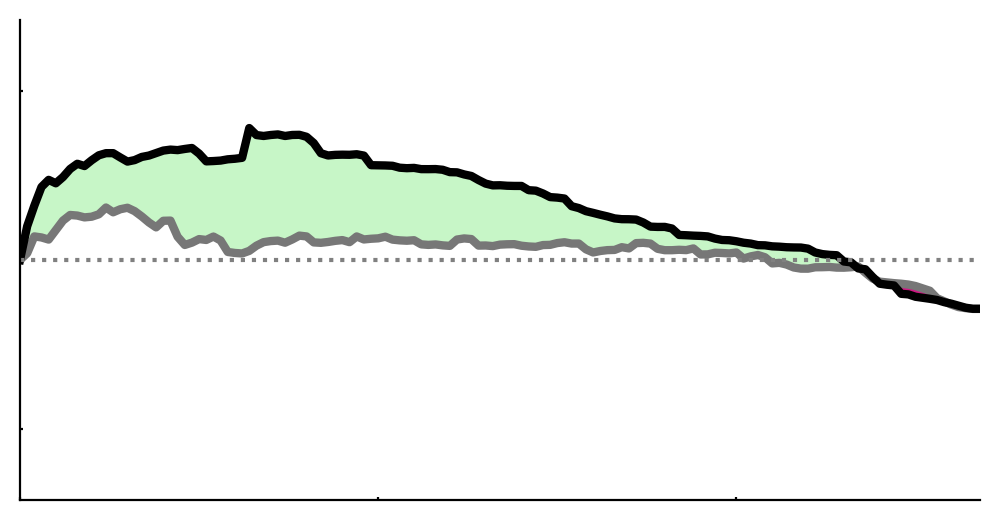

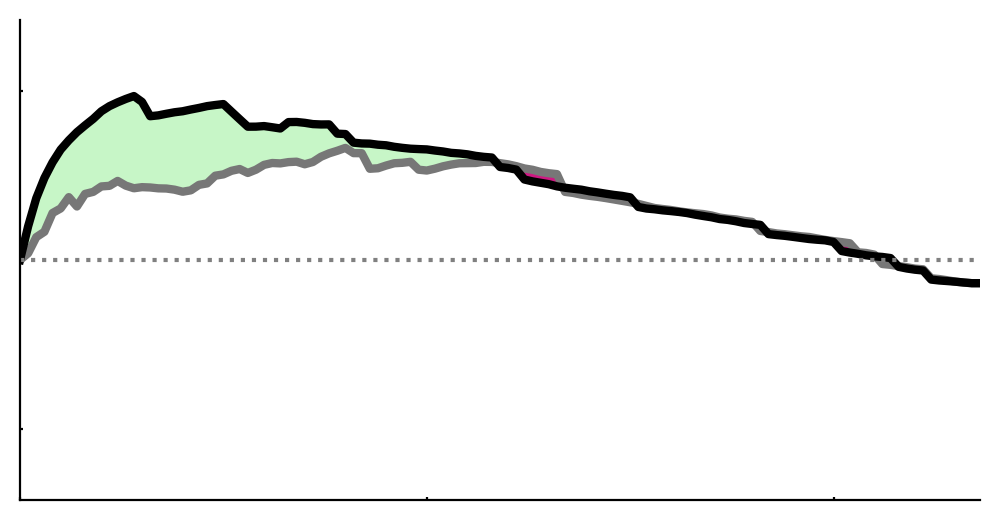

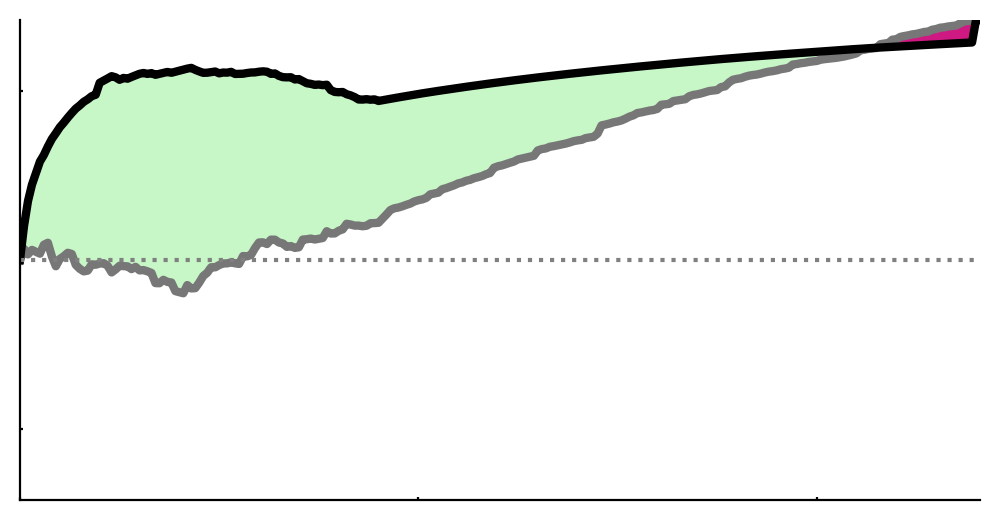

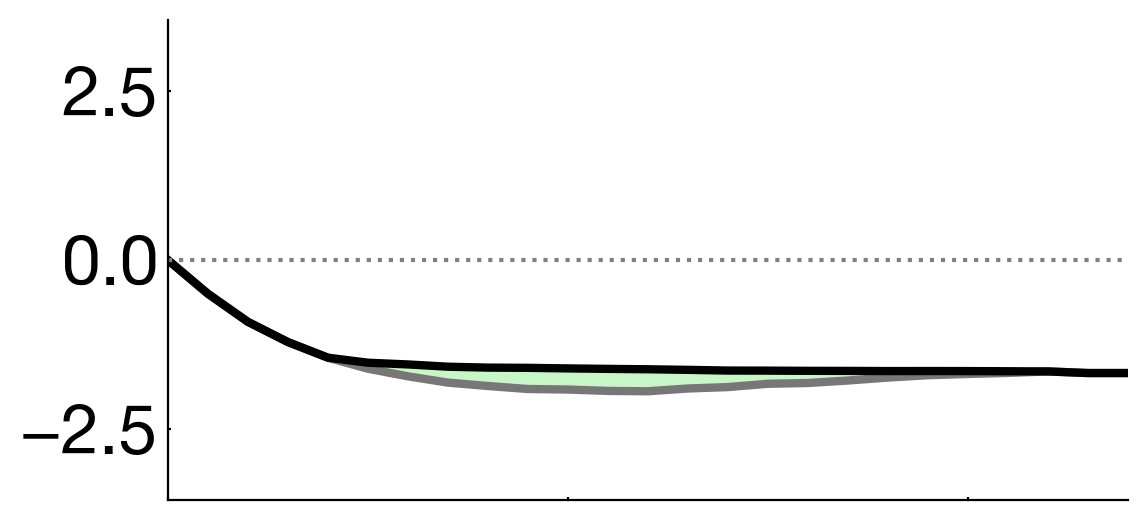

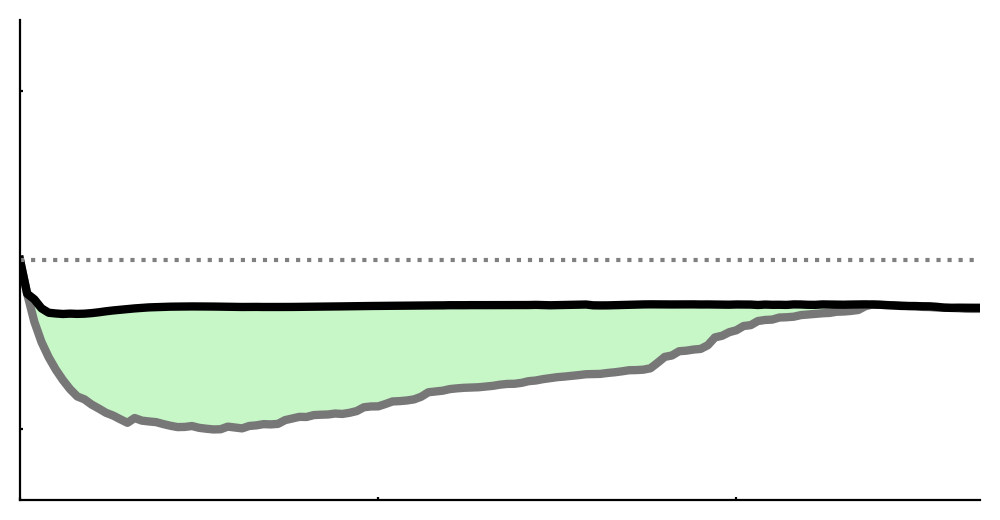

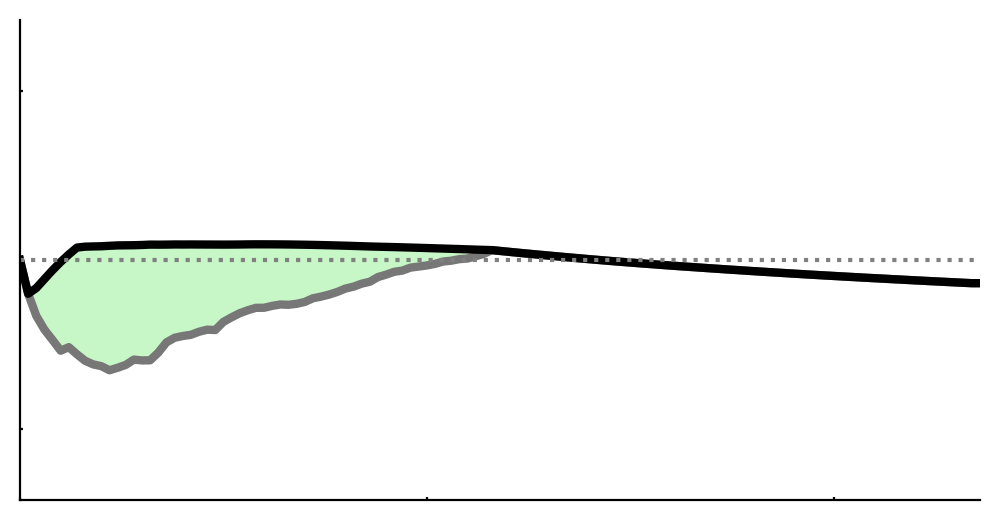

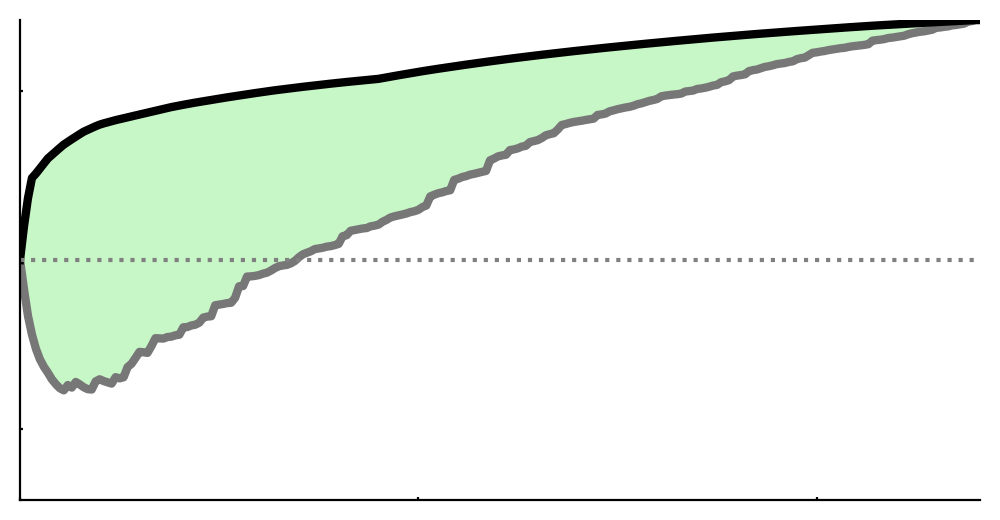

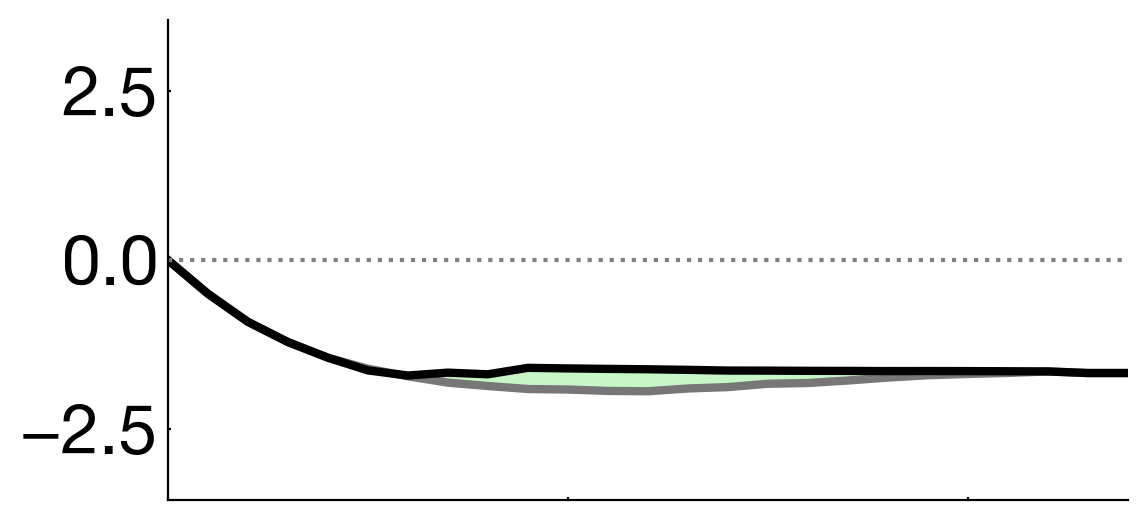

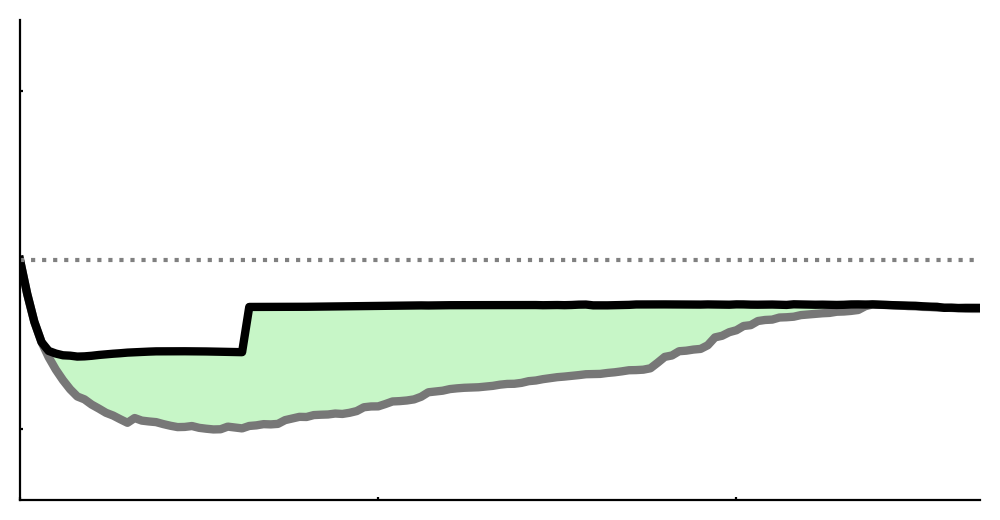

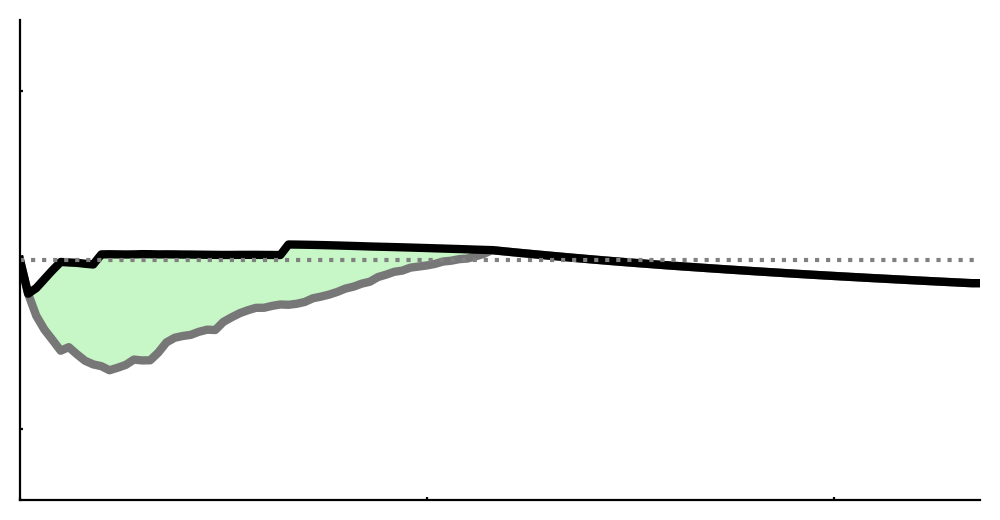

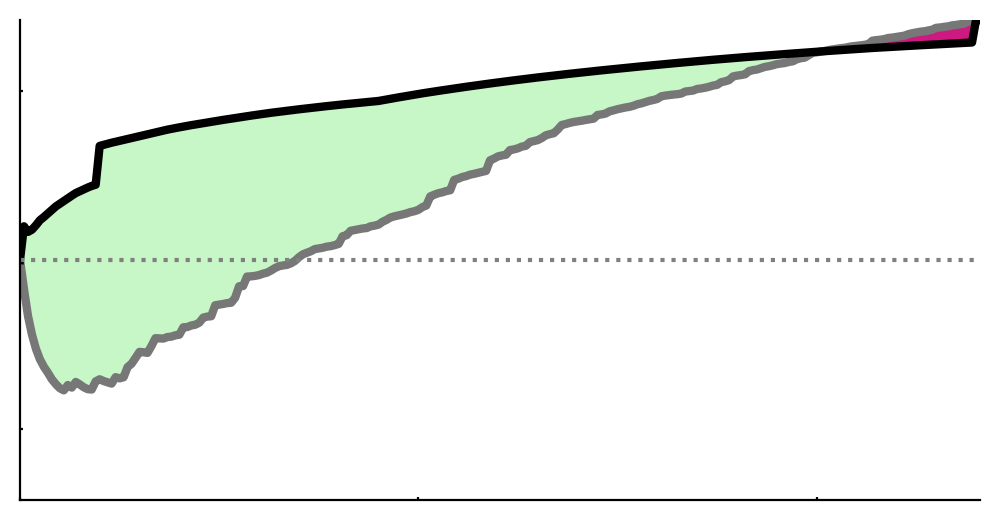

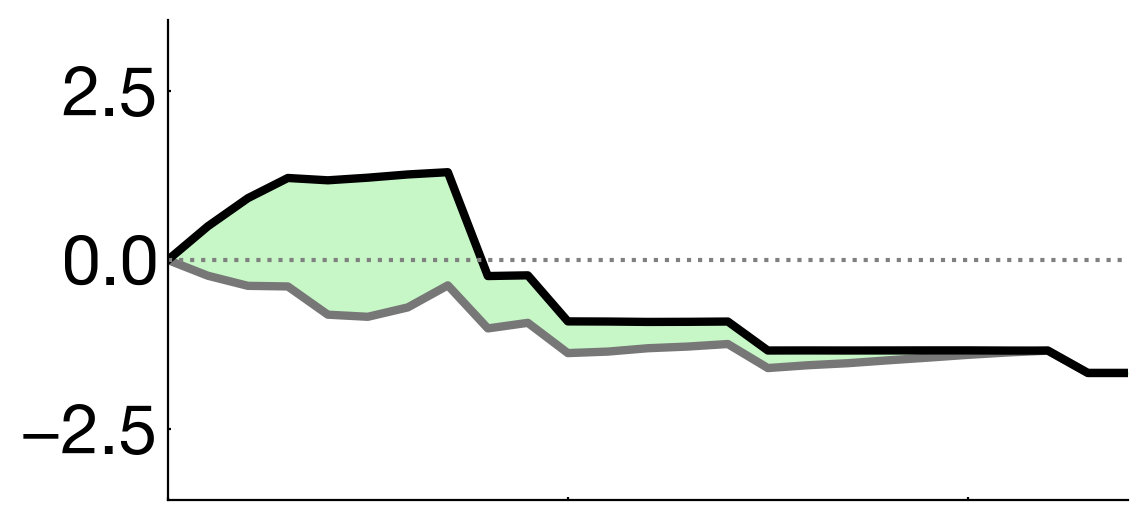

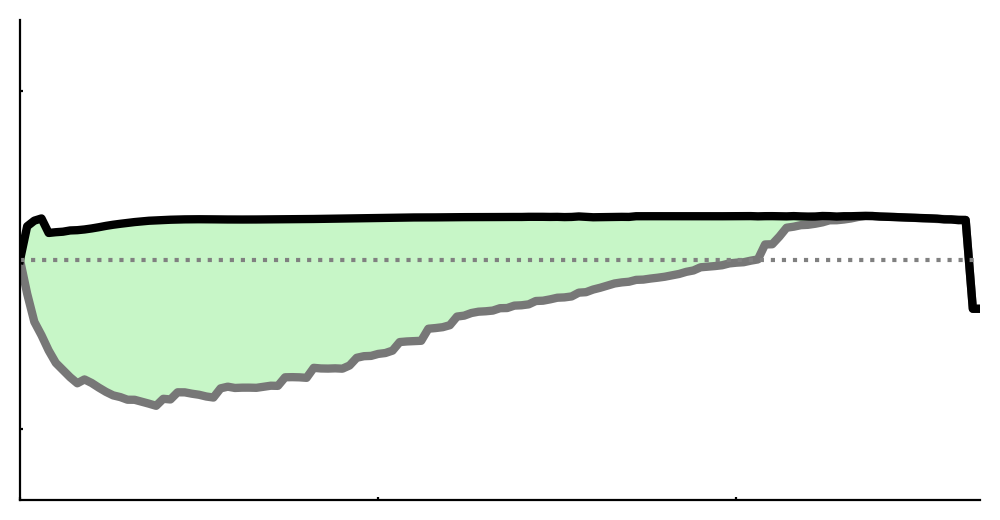

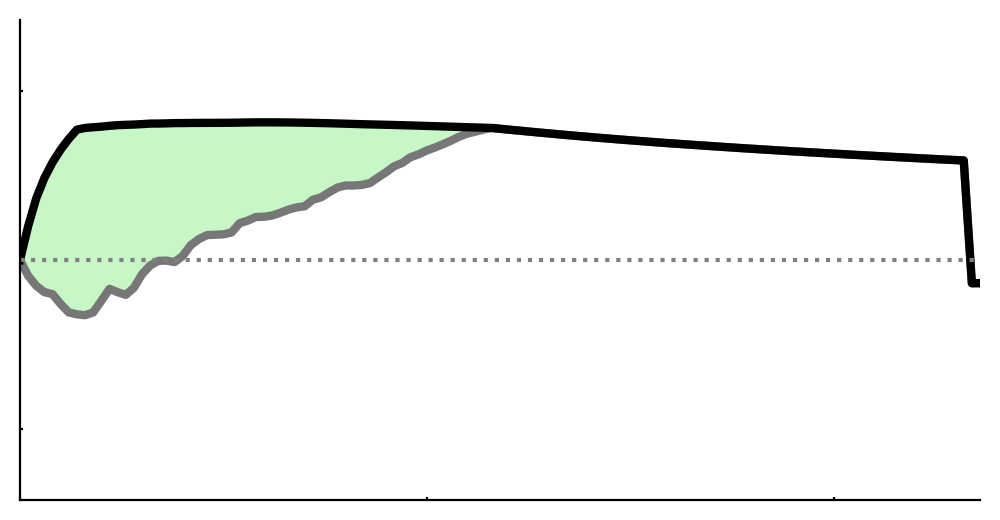

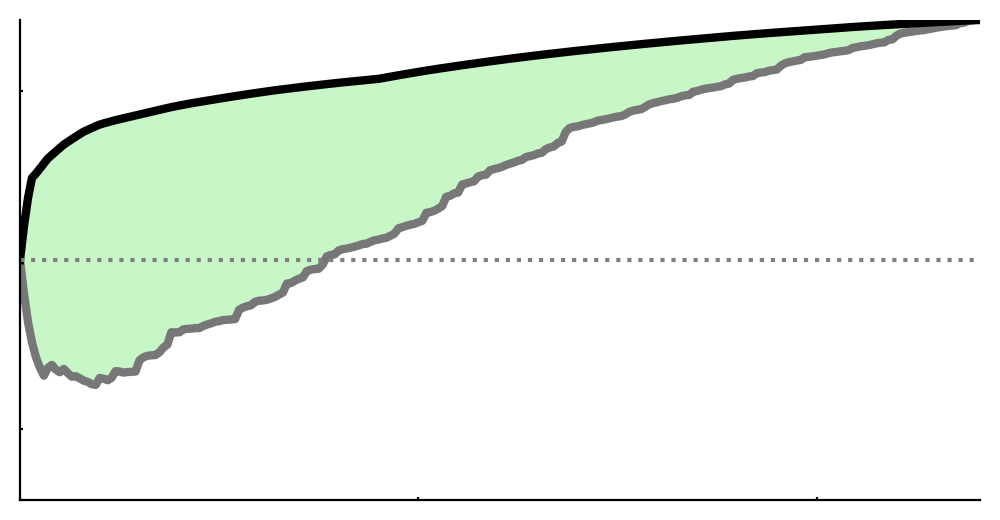

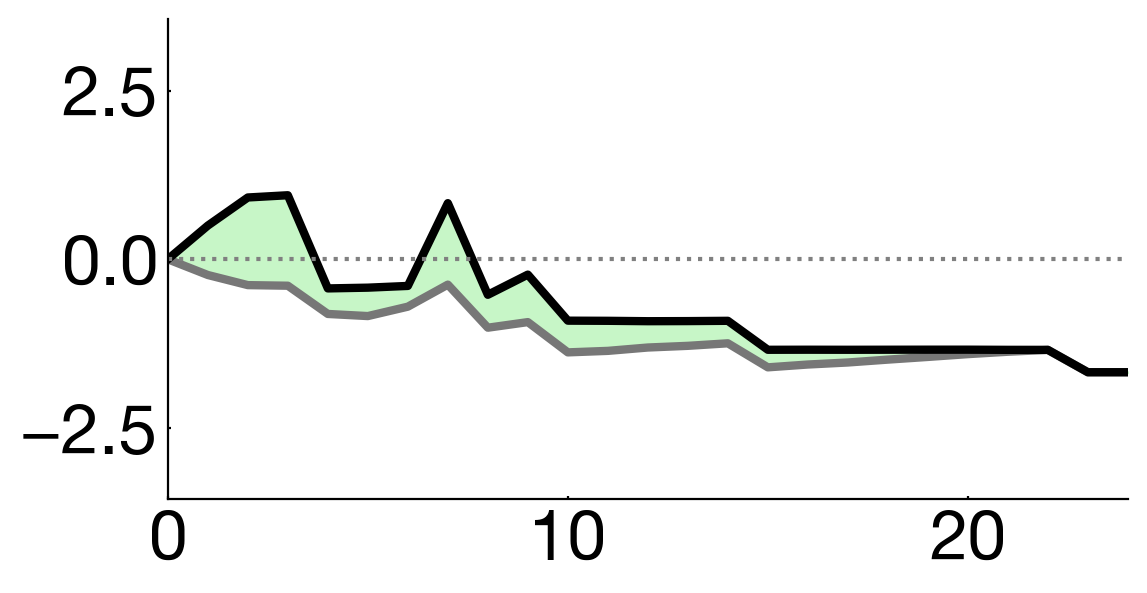

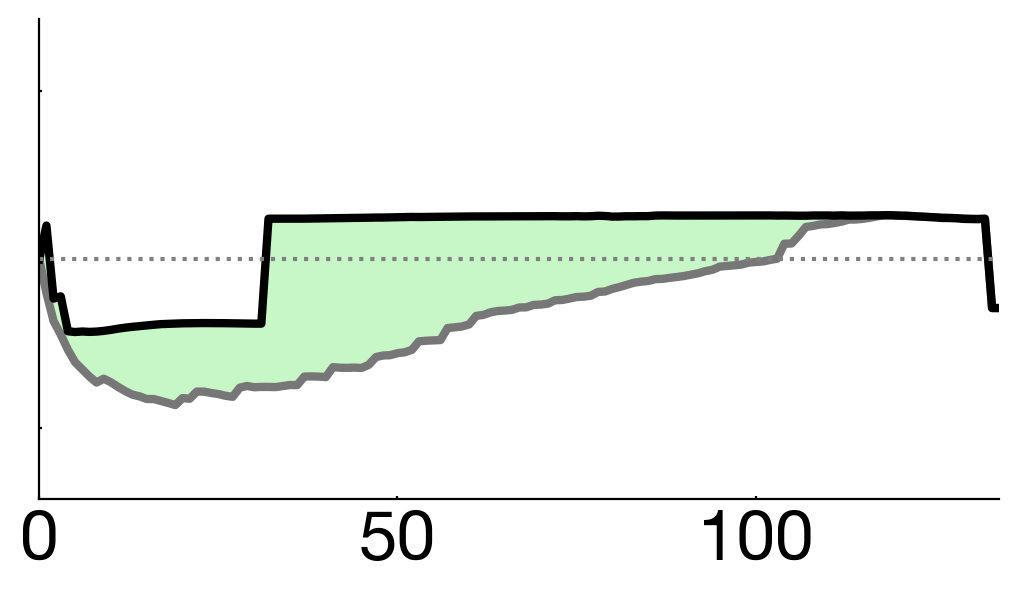

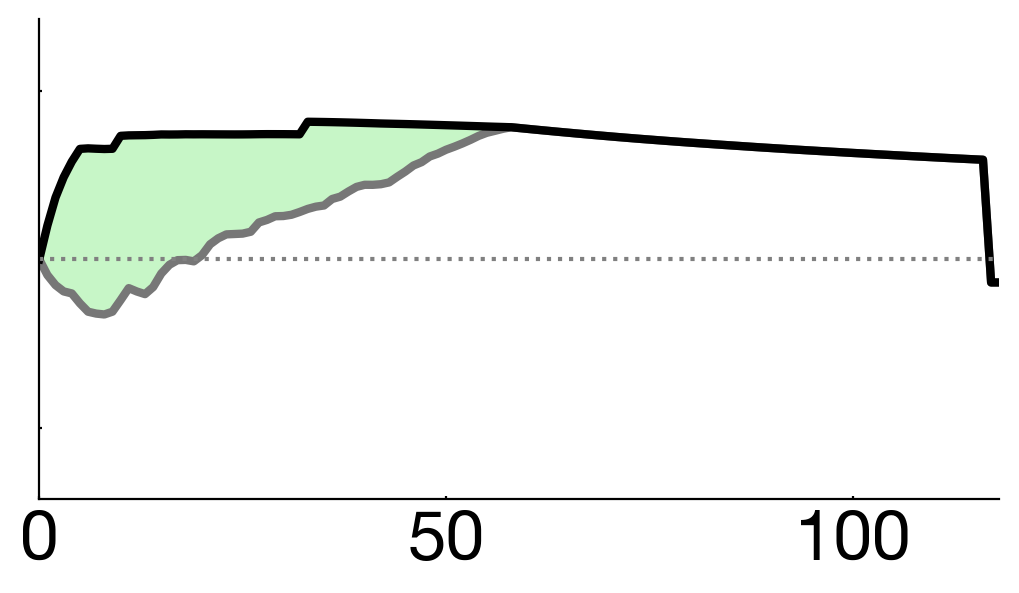

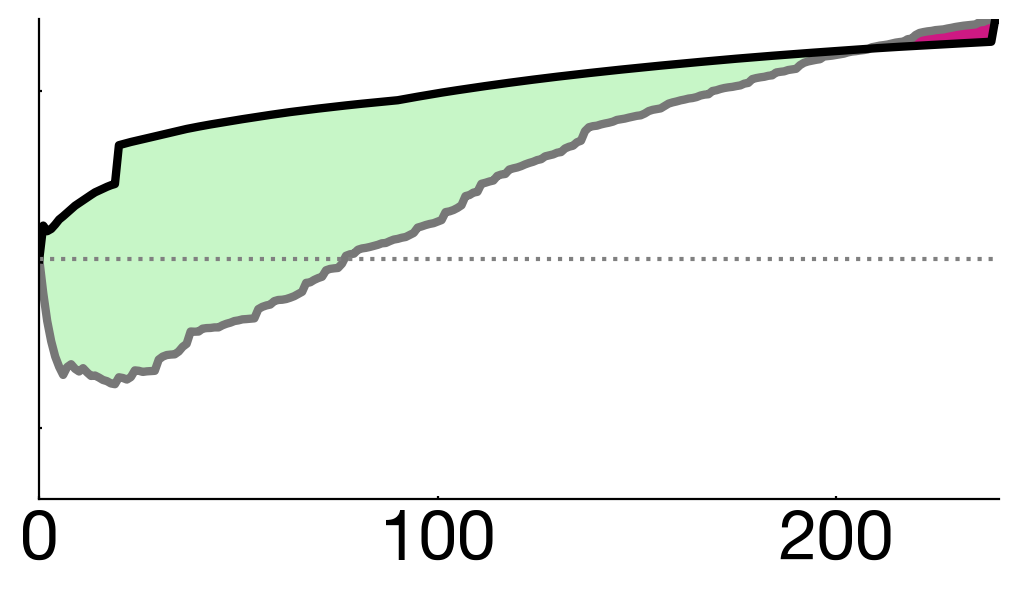

In [19]:
import math 

results_tb = open('results/evaluation-all-topics-against-disinformer.html', 'w')

results_tb.write("""
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Strategy evaluation against disinformer</title>
  <script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML"> </script>
  <style>
    body, html {
      font-family: Helvetica Neue;
      font-size: 23px;
    }

    @font-face {
      font-family: 'Computer Modern Classical Serif Italic';
      src: url('cmunci.eot');
      src: url('cmunci.eot?#iefix') format('embedded-opentype'),
        url('cmunci.woff') format('woff'),
        url('cmunci.ttf') format('truetype'),
        url('cmunci.svg#cmunci') format('svg');
      font-weight: normal;
      font-style: italic;
    }

    i {
      font-family: "Computer Modern Classical Serif Italic", serif;
    }
    table, thead, tbody, tfoot, tr, th, td {
      width: auto;
      height: auto;
      margin: 0;
      padding: 0;
      border: none;
      border-collapse: inherit;
      border-spacing: 0;
      border-color: inherit;
      vertical-align: inherit;
      text-align: center;
      font-weight: inherit;
      -webkit-border-horizontal-spacing: 0;
      -webkit-border-vertical-spacing: 0;
    }
    th {
      font-size: 300%;
      vertical-align: middle;
    }
    th[rowspan] {
      writing-mode: vertical-lr;
      transform: rotate(180deg);
      padding: 5px;
    }
    th[rowspan] {
      padding: 5px;
      font-weight: bold;
    }
    th.mitigator-strategy {
      padding: 5px;
      min-width: 200px;
      white-space: nowrap;
    }
    .test-label, .base-label {
      font-size: 300%;
    }
    .split-line { 
      padding: 50px;
    }
    .topics {
      font-weight: bold;
    }
  </style>
</head>
<body>
 <p>\( x =  E_m(U_t) - E_d(U_t) \)</p>
""")

results_tb.write('<table>\n')

results_tb.write('<tr>\n')
results_tb.write(f"  <th> </th>\n")
results_tb.write(f"  <th> </th>\n")
for topic in datavoids_per_topic.keys():
  topic_parts = topic.split(' vs ')
  if flipped:
    results_tb.write(f"  <th>\( m = \) {topic_parts[1]} </br> \( d = \) {topic_parts[0]}</th>\n")
  else:
    results_tb.write(f"  <th>\( m = \) {topic_parts[0]} </br> \( d = \) {topic_parts[1]}</th>\n")
results_tb.write("</tr>\n")

plot_y_max = 0
plot_y_min = 0
min_step_no = {topic: math.inf for topic in datavoids_per_topic.keys()}
for find_y_max in [True, False]:
  for dis_idx, disinformer_strategy_class in enumerate(strategies_to_run):
    if not find_y_max:
      results_tb.write("<tr>\n")
    disinformer_strategy_base = disinformer_strategy_class()
    mitigator_strategy_base = RandomStrategy()
    if not find_y_max:
      results_tb.write(f"  <th rowspan=\"{len(strategies_to_run) - 1}\">\( d = \) " + readable_strategy_name(disinformer_strategy_base) + "</th>\n")
    simulation_label_base = f'eval-all-base-{mitigator_strategy_base.get_strategy_name()}-{disinformer_strategy_base.get_strategy_name()}'

    for mit_idx, mitigator_strategy_class in enumerate(strategies_to_run):
      disinformer_strategy = disinformer_strategy_class()
      mitigator_strategy = mitigator_strategy_class()
      simulation_label = f'eval-all-{mitigator_strategy.get_strategy_name()}-{disinformer_strategy.get_strategy_name()}'

      if disinformer_strategy.get_strategy_name() == disinformer_strategy_base.get_strategy_name() and \
          mitigator_strategy.get_strategy_name() == mitigator_strategy_base.get_strategy_name():
        continue

      if not find_y_max:
        results_tb.write(f"  <th class=\"mitigator-strategy\">\( m = \) " + readable_strategy_name(mitigator_strategy) + "<br/>Differences in Effect \( E_m(U_t) - E_d(U_t) \) " + "</th>\n")

      for topic_idx, topic in enumerate(datavoids_per_topic.keys()):
        topic_parts = topic.split(' vs ')
        mitigator_id = datavoids_per_topic[topic]['mitigator_id']
        disinformer_id = datavoids_per_topic[topic]['disinformer_id']
        mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
        disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
        current_config = None
        topic_label = f"{mitigator_label}-{disinformer_label}"

        if flipped:
          current_config = clone_config_with_target(config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
          current_config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
        else:
          current_config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
          current_config['topic_name'] = topic 

        datavoids = datavoids_per_topic[topic]['datavoids']
        current_config['datavoids'] = [datavoids]

        sim_filename_base = 'results/' + create_simulation_name(current_config, simulation_label_base)
        sim_filename = 'results/' + create_simulation_name(current_config, simulation_label)
        plot_filename = f'results/images_against_disinformer/{topic_label}-{simulation_label_base}-{simulation_label}.png'
        plot_filename_pdf = f'results/images_against_disinformer/{topic_label}-{simulation_label_base}-{simulation_label}.pdf'

        if not os.path.exists(sim_filename_base) or not os.path.exists(sim_filename):
          continue

        current_config["output_filename"] = sim_filename_base
        steps_per_strategy_base, strategies_base, id_max_rank_base = get_output(current_config)

        current_config["output_filename"] = sim_filename
        steps_per_strategy, strategies, id_max_rank = get_output(current_config)

        if find_y_max:
          res = plot_differences_against_opponent_base_ranges(
            current_config['target_groups'][0],
            current_config['target_groups'][1],
            strategies_base[0],
            strategies[0], 
            steps_per_strategy_base, 
            steps_per_strategy, 
            current_config,
          )
          if res[1] > plot_y_max:
            plot_y_max = res[1]
          if res[0] < plot_y_min:
            plot_y_min = res[0]
          if res[2] < min_step_no[topic]:
            min_step_no[topic] = res[2]

          abs_y_max = max(abs(plot_y_max), abs(plot_y_min))
          plot_y_min = - abs_y_max
          plot_y_max = abs_y_max
        else:
          plot_fig = plot_differences_against_opponent_base(
            None,
            current_config['target_groups'][0],
            current_config['target_groups'][1],
            strategies_base[0],
            strategies[0], 
            steps_per_strategy_base, 
            steps_per_strategy, 
            current_config,
            y_max=plot_y_max,
            y_min=plot_y_min,
            steps_no=min_step_no[topic],
            show=False,
            plot_y_axis= (topic_idx == 0),
            plot_x_axis= (dis_idx == len(strategies_to_run) - 1 and mit_idx == len(strategies_to_run) - 1),
            show_legend=False
          )
          plot_fig.savefig(plot_filename, bbox_inches='tight')
          plot_fig.savefig(plot_filename_pdf, bbox_inches='tight')

        if not find_y_max:
          results_tb.write(f"""  <td>
                <div class="base-label">base: {mitigator_strategy_base.get_strategy_name()} vs {disinformer_strategy_base.get_strategy_name()}</div>
                <div class="test-label">test: {mitigator_strategy.get_strategy_name()} vs {disinformer_strategy.get_strategy_name()}</div>
                <div>{plot_filename_pdf.replace("results/images_against_disinformer/", "")}</div>
                <img src=\"{plot_filename.replace("results/", "")}\" /></td>\n
              """)

        print('.', end='')

      if not find_y_max:
        results_tb.write("</tr>\n")

    if not find_y_max:
      results_tb.write("</tr>")
      if dis_idx < len(strategies_to_run) - 1:
        results_tb.write(f"<tr><td class=\"split-line\" colspan=\"{len(datavoids_per_topic.keys()) + 2}\"></td></tr>")
      
results_tb.write('<tr>\n')
results_tb.write(f"  <th> </th>\n")
results_tb.write(f"  <th> </th>\n")
for topic in datavoids_per_topic.keys():
  topic_parts = topic.split(' vs ')
  results_tb.write(f"  <th>Simulation Steps</th>\n")
results_tb.write("</tr>\n")

results_tb.write("</table>")

results_tb.write("</body></html>")

results_tb.close()

plot_y_max

## Costs Table

....

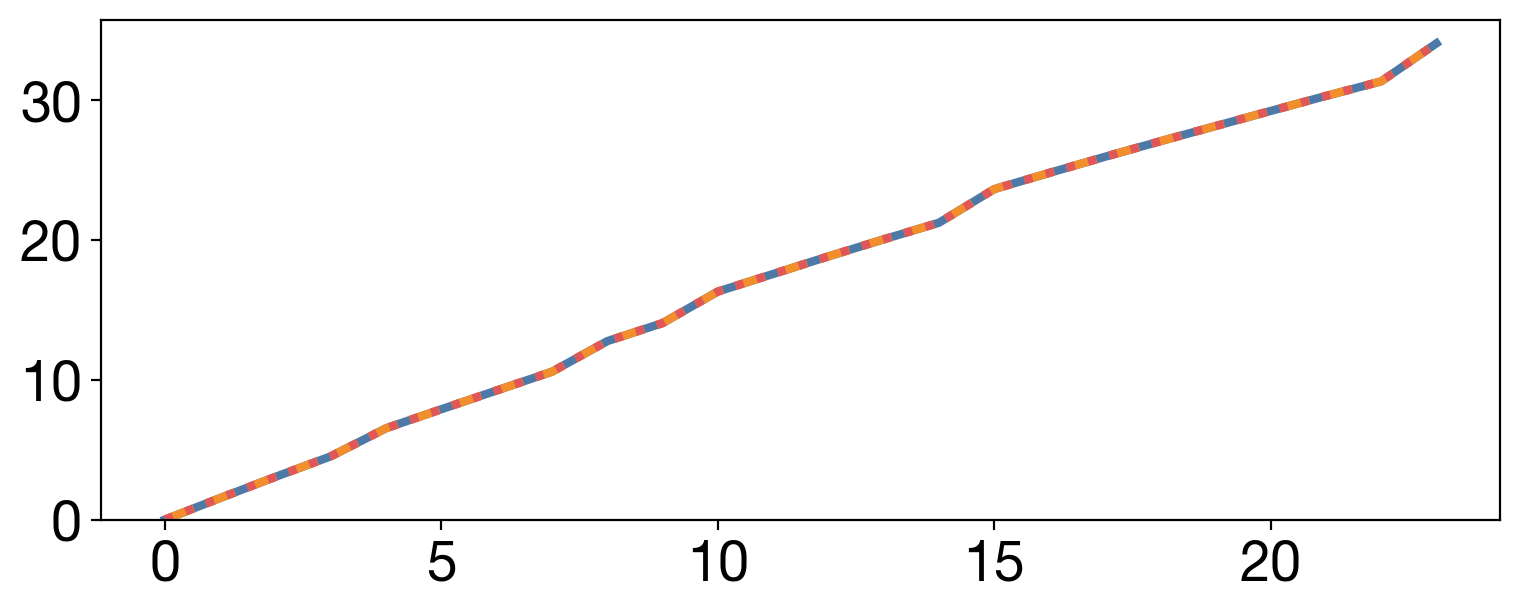

.

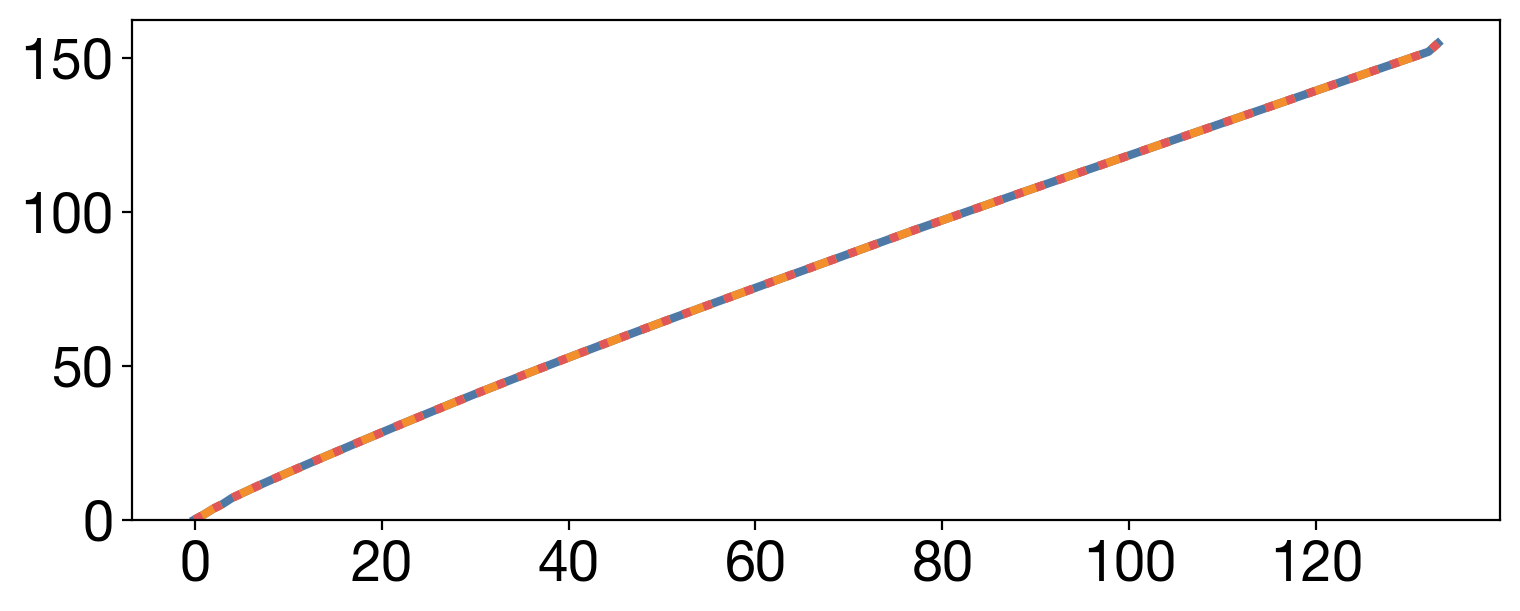

.

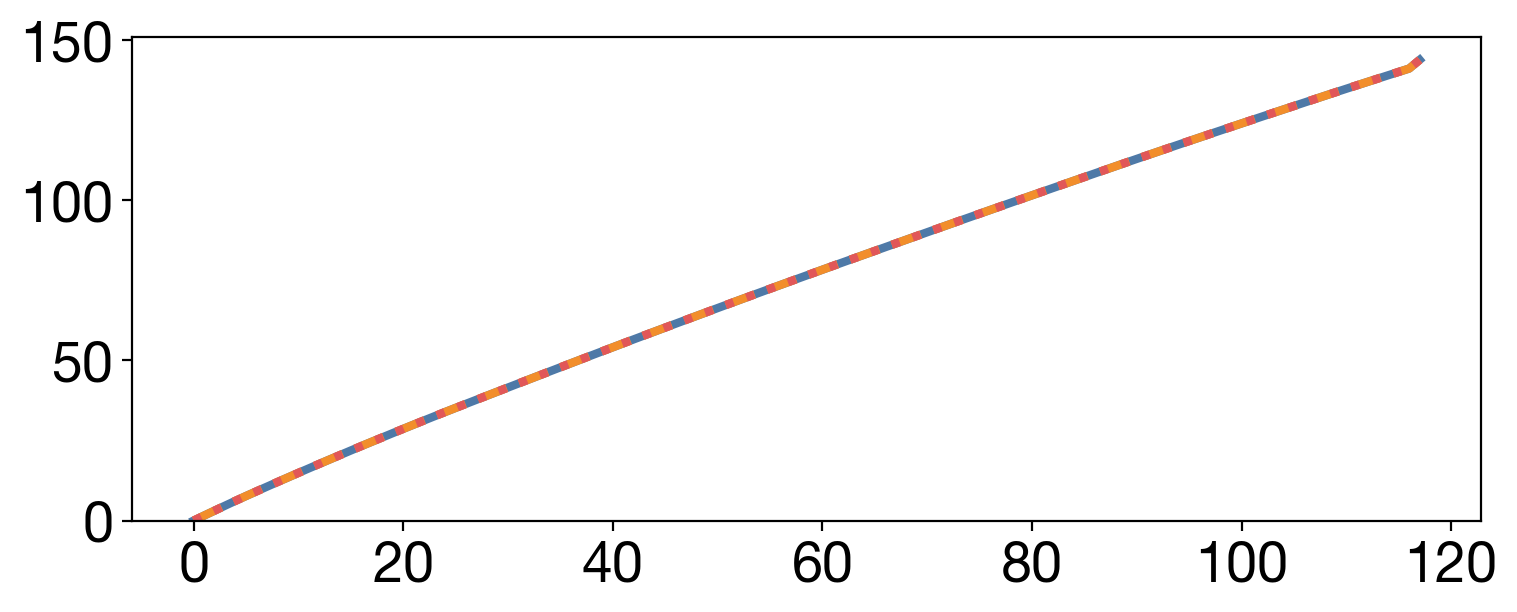

.

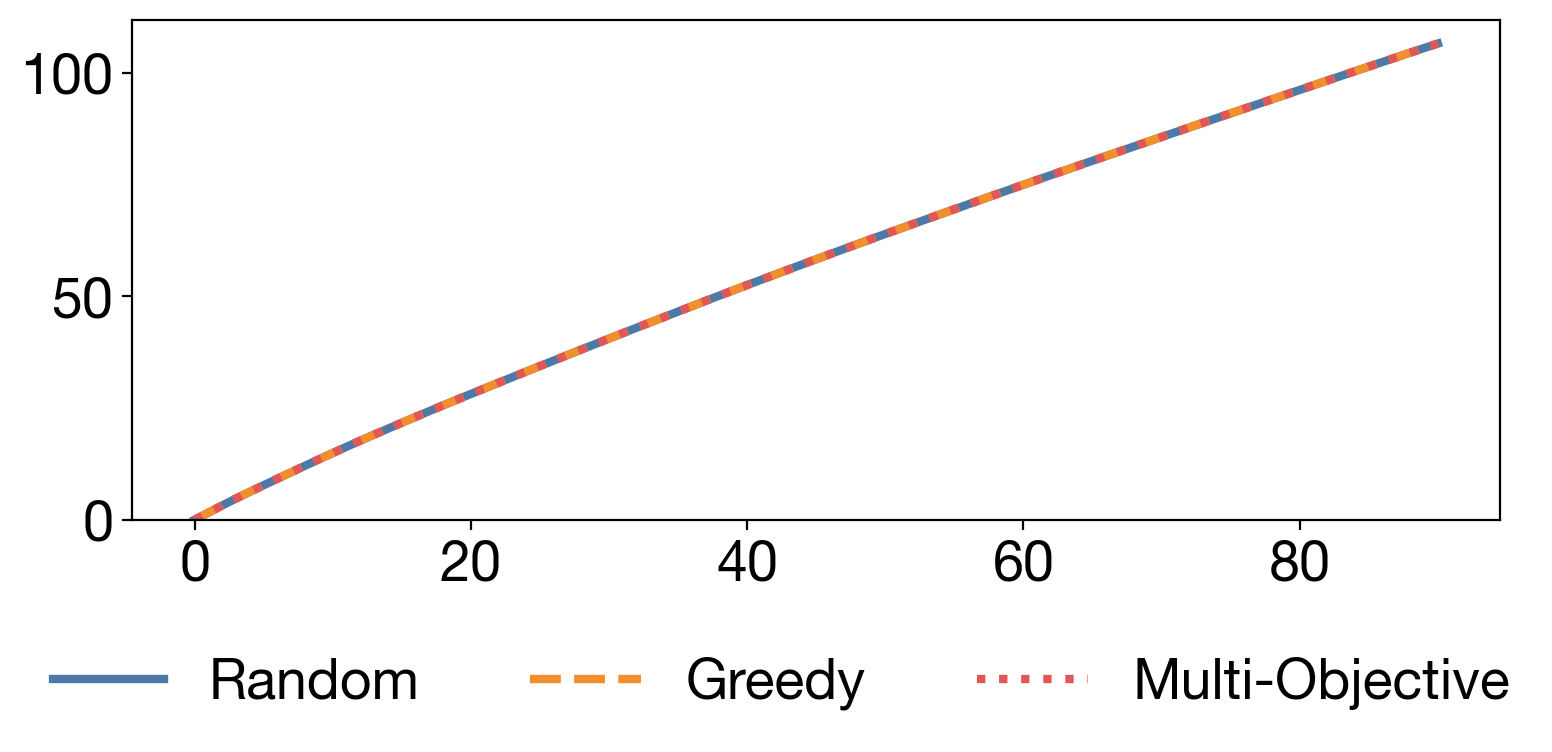

.

{'Declarative Language vs Procedural Language': 34.05458658911145,
 'Optimism vs Pessimism': 154.74107944473536,
 'Rationalism vs Empiricism': 143.84843716095767,
 'Classical Economics vs Keynesian Economics': 106.6122940036816}

In [20]:
import math 

results_tb = open('results/costs-evaluation-all-topics-against-disinformer.html', 'w')

results_tb.write("""
<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <title>Strategy evaluation against disinformer</title>
  <style>
    body, html {
      font-family: Helvetica Neue;
      font-size: 20px;
    }
    i {
      font-family: Times New Roman;
    }
    table, thead, tbody, tfoot, tr, th, td {
      width: auto;
      height: auto;
      margin: 0;
      padding: 0;
      border: none;
      border-collapse: inherit;
      border-spacing: 0;
      border-color: inherit;
      vertical-align: inherit;
      text-align: center;
      font-weight: inherit;
      -webkit-border-horizontal-spacing: 0;
      -webkit-border-vertical-spacing: 0;
    }
    th {
      font-size: 300%;
      vertical-align: center;
    }
    th.strategy-label, th.mitigator-strategy {
      writing-mode: vertical-lr;
      transform: rotate(180deg);
    }
    .test-label, .base-label {
      font-size: 300%;
    }
    .split-line { 
      padding: 50px;
    }
  </style>
</head>
<body>
""")

results_tb.write('<table border="1"><tr>\n')
for topic in datavoids_per_topic.keys():
  topic_parts = topic.split(' vs ')
  if flipped:
    results_tb.write(f"<th><i>m =</i> {topic_parts[1]} </br> <i>d</i> = {topic_parts[0]}</th>")
  else:
    results_tb.write(f"<th><i>m =</i> {topic_parts[0]} </br> <i>d</i> = {topic_parts[1]}</th>")
results_tb.write("</tr>")

plot_y_max = {topic: 0 for topic in datavoids_per_topic.keys()} 
plot_y_min = {topic: 0 for topic in datavoids_per_topic.keys()} 
min_step_no = {topic: math.inf for topic in datavoids_per_topic.keys()}
for find_y_max in [True, False]:
  if not find_y_max:
    results_tb.write("<tr>\n")
  disinformer_strategy_base = RandomStrategy()
  mitigator_strategy_base = RandomStrategy()
  simulation_label_base = f'eval-all-base-{mitigator_strategy_base.get_strategy_name()}-{disinformer_strategy_base.get_strategy_name()}'

  for topic_idx, topic in enumerate(datavoids_per_topic.keys()):
    topic_parts = topic.split(' vs ')

    mitigator_id = datavoids_per_topic[topic]['mitigator_id']
    disinformer_id = datavoids_per_topic[topic]['disinformer_id']
    mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
    disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
    current_config = None
    topic_label = f"{mitigator_label}-{disinformer_label}"

    if flipped:
      current_config = clone_config_with_target(config, disinformer_label, mitigator_label, disinformer_id, mitigator_id)
      current_config['topic_name'] = topic_parts[1] + ' vs ' + topic_parts[0]
    else:
      current_config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)
      current_config['topic_name'] = topic 

    datavoids = datavoids_per_topic[topic]['datavoids']
    current_config['datavoids'] = [datavoids]
    plot_filename = f'results/costs_images_against_disinformer/{topic_label}-{simulation_label_base}.png'
    plot_filename_pdf = f'results/costs_images_against_disinformer/{topic_label}-{simulation_label_base}.pdf'
    steps_per_strategy_per_set_up = {}
    for mitigator_strategy_class in strategies_to_run:
      disinformer_strategy = disinformer_strategy_class()
      mitigator_strategy = mitigator_strategy_class()
      simulation_label = f'eval-all-{mitigator_strategy.get_strategy_name()}-{disinformer_strategy.get_strategy_name()}'
      sim_filename = 'results/' + create_simulation_name(current_config, simulation_label)


      if os.path.exists(sim_filename):
        current_config["output_filename"] = sim_filename
        steps_per_strategy, strategies, id_max_rank = get_output(current_config)
        steps_per_strategy_per_set_up[readable_strategy_name(mitigator_strategy)] = steps_per_strategy[strategies[0]]
    
    if not steps_per_strategy_per_set_up:
      continue

    if find_y_max:
      res = plot_group_costs_multiple_set_ups_ranges(
        mitigator_label if flipped else disinformer_label,
        steps_per_strategy_per_set_up, 
        current_config
      )
      if res[1] > plot_y_max[topic]:
        plot_y_max[topic] = res[1]
      if res[0] < plot_y_min[topic]:
        plot_y_min[topic] = res[0]
    else:
      plot_fig = plot_group_costs_multiple_set_ups(
        mitigator_label if flipped else disinformer_label,
        steps_per_strategy_per_set_up, 
        current_config,
        print_legend= (topic_idx == len(datavoids_per_topic.keys()) - 1)
      )
      plot_fig.savefig(plot_filename)
      plot_fig.savefig(plot_filename_pdf)

    if not find_y_max:
      #<div class="base-label">base: {mitigator_strategy_base.get_strategy_name()} vs {disinformer_strategy_base.get_strategy_name()}</div>
      results_tb.write(f"""<td>
        <img src=\"{plot_filename.replace("results/", "")}\" />
      </td>""")

    print('.', end='')

  if not find_y_max:
    results_tb.write("</tr>\n")

results_tb.write("</table>")
results_tb.write("</body></html>")

results_tb.close()

plot_y_max